<a href="https://colab.research.google.com/github/kbssrikar7/streamlit_heart_app/blob/main/oneLastTime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cardio_train_extended.csv to cardio_train_extended (1).csv


In [ ]:
# Cell 2 - imports and constants
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report)

# reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# file path - update if using Google Drive mount
DATA_PATH = "/content/cardio_train_extended.csv"  # or "/mnt/data/cardio_train_extended.csv"

In [ ]:
# Cell 3 - load dataset
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())
print("\nColumn types:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isna().sum())

Shape: (70000, 32)


id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   ...                                     Reason  Pulse_Pressure_Ratio  \
0  ...                         Healthy indicators              0.272727   
1  ...  High BMI (>30), High BP, High cholesterol              0.357143   
2  ...                 High cholesterol, Inactive              0.461538   
3  ...                                    High BP              0.333333   
4  ...                                   Inactive              0.400000   

          MAP  BMI_Category  Smoker_Alcoholic  BP_Category  Risk_Age  \
0   90.000000        Normal                 0      Stage 1        50   
1  106.666667         Obese                 0      Stage 2        61   
2   90.000000        Normal                 0      Stage 1        51   
3  116.666667    Overweight                 0      Stage 2        51   
4   73.333333        Normal                 0       Normal        47   

  Risk_Level  Protein_Level  Ejection_Fraction  
0        Low           7.23               56.8  
1       High           6.53               45.1  
2   Moderate           6.92               55.6  
3   Moderate           7.36               43.9  
4        Low           7.23               62.0  

[5 rows x 32 columns]


Column types:
id                        int64
age                       int64
gender                    int64
height                    int64
weight                  float64
ap_hi                     int64
ap_lo                     int64
cholesterol               int64
gluc                      int64
smoke                     int64
alco                      int64
active                    int64
cardio                    int64
BMI                     float64
BP_diff                   int64
Systolic_Pressure         int64
age_years                 int64
Age_Group                object
Lifestyle_Score           int64
Obesity_Flag              int64
Hypertension_Flag         int64
Health_Risk_Score         int64
Reason                   object
Pulse_Pressure_Ratio    float64
MAP                     float64
BMI_Category             object
Smoker_Alcoholic          int64
BP_Category              object
Risk_Age                  int64
Risk_Level               object
Protein_Level           f

In [ ]:
print("Shape:", df.shape)
print("Duplicate rows:", df.duplicated().sum())
print("\nTarget distribution:\n", df['cardio'].value_counts(normalize=True))
df.describe(include='all').T.head(20)

Shape: (70000, 32)
Duplicate rows: 0

Target distribution:
 cardio
0    0.5003
1    0.4997
Name: proportion, dtype: float64


count unique    top   freq          mean           std  \
id                 70000.0    NaN    NaN    NaN    49972.4199  28851.302323   
age                70000.0    NaN    NaN    NaN  19468.865814   2467.251667   
gender             70000.0    NaN    NaN    NaN      1.349571      0.476838   
height             70000.0    NaN    NaN    NaN    164.359229      8.210126   
weight             70000.0    NaN    NaN    NaN      74.20569     14.395757   
ap_hi              70000.0    NaN    NaN    NaN    128.817286    154.011419   
ap_lo              70000.0    NaN    NaN    NaN     96.630414     188.47253   
cholesterol        70000.0    NaN    NaN    NaN      1.366871       0.68025   
gluc               70000.0    NaN    NaN    NaN      1.226457       0.57227   
smoke              70000.0    NaN    NaN    NaN      0.088129      0.283484   
alco               70000.0    NaN    NaN    NaN      0.053771      0.225568   
active             70000.0    NaN    NaN    NaN      0.803729      0.397179   
cardio             70000.0    NaN    NaN    NaN        0.4997      0.500003   
BMI                70000.0    NaN    NaN    NaN     27.556513      6.091511   
BP_diff            70000.0    NaN    NaN    NaN     32.186871    241.469638   
Systolic_Pressure  70000.0    NaN    NaN    NaN    128.817286    154.011419   
age_years          70000.0    NaN    NaN    NaN     52.840671      6.766774   
Age_Group            70000      5  50-59  35541           NaN           NaN   
Lifestyle_Score    70000.0    NaN    NaN    NaN      0.338171       0.56754   
Obesity_Flag       70000.0    NaN    NaN    NaN        0.2639      0.440749   

                        min        25%        50%        75%         max  
id                      0.0   25006.75    50001.5   74889.25     99999.0  
age                 10798.0    17664.0    19703.0    21327.0     23713.0  
gender                  1.0        1.0        1.0        2.0         2.0  
height                 55.0      159.0      165.0      170.0       250.0  
weight                 10.0       65.0       72.0       82.0       200.0  
ap_hi                -150.0      120.0      120.0      140.0     16020.0  
ap_lo                 -70.0       80.0       80.0       90.0     11000.0  
cholesterol             1.0        1.0        1.0        2.0         3.0  
gluc                    1.0        1.0        1.0        1.0         3.0  
smoke                   0.0        0.0        0.0        0.0         1.0  
alco                    0.0        0.0        0.0        0.0         1.0  
active                  0.0        1.0        1.0        1.0         1.0  
cardio                  0.0        0.0        0.0        1.0         1.0  
BMI                3.471784  23.875115  26.374068  30.222222  298.666667  
BP_diff            -10800.0       40.0       40.0       50.0     15940.0  
Systolic_Pressure    -150.0      120.0      120.0      140.0     16020.0  
age_years              29.0       48.0       53.0       58.0        64.0  
Age_Group               NaN        NaN        NaN        NaN         NaN  
Lifestyle_Score         0.0        0.0        0.0        1.0         3.0  
Obesity_Flag            0.0        0.0        0.0        1.0         1.0

In [ ]:
df['ap_hi'] = df['ap_hi'].clip(lower=80, upper=250)
df['ap_lo'] = df['ap_lo'].clip(lower=40, upper=150)
df['BMI'] = df['BMI'].clip(lower=10, upper=60)


df['BP_diff'] = df['ap_hi'] - df['ap_lo']


df[['ap_hi', 'ap_lo', 'BP_diff', 'BMI']].describe()

ap_hi         ap_lo       BP_diff           BMI
count  70000.000000  70000.000000  70000.000000  70000.000000
mean     126.948729     82.277486     44.671243     27.508972
std       17.481877     12.501876     13.729150      5.324786
min       80.000000     40.000000    -70.000000     10.000000
25%      120.000000     80.000000     40.000000     23.875115
50%      120.000000     80.000000     40.000000     26.374068
75%      140.000000     90.000000     50.000000     30.222222
max      250.000000    150.000000    210.000000     60.000000

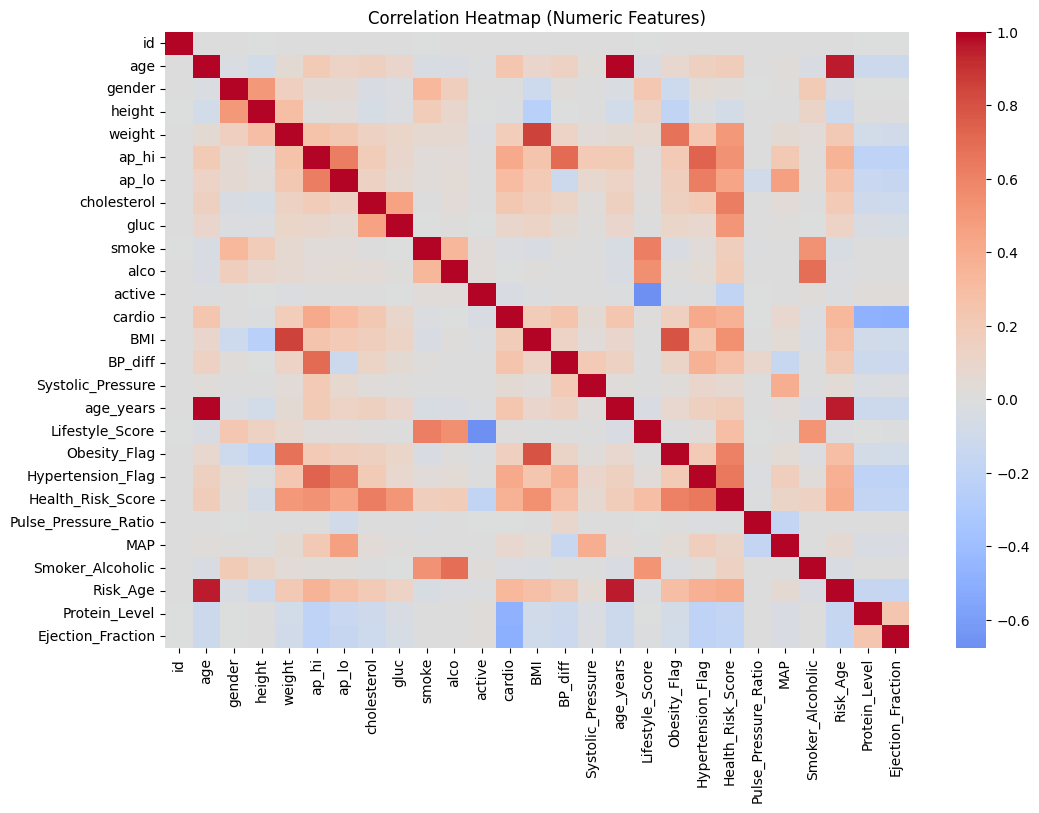

cardio                  1.000000
ap_hi                   0.419081
Hypertension_Flag       0.416536
Health_Risk_Score       0.364693
Risk_Age                0.326179
ap_lo                   0.307140
BP_diff                 0.253949
age                     0.238159
age_years               0.237985
cholesterol             0.221147
BMI                     0.189252
weight                  0.181660
Obesity_Flag            0.156880
gluc                    0.089307
MAP                     0.080986
Systolic_Pressure       0.054475
Lifestyle_Score         0.014303
gender                  0.008109
id                      0.003799
Pulse_Pressure_Ratio   -0.003572
alco                   -0.007330
height                 -0.010821
smoke                  -0.015486
Smoker_Alcoholic       -0.018228
active                 -0.035653
Protein_Level          -0.485889
Ejection_Fraction      -0.493570
Name: cardio, dtype: float64

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

num_features = df.select_dtypes(include='number').columns
corr = df[num_features].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


corr_target = corr['cardio'].sort_values(ascending=False)
display(corr_target)

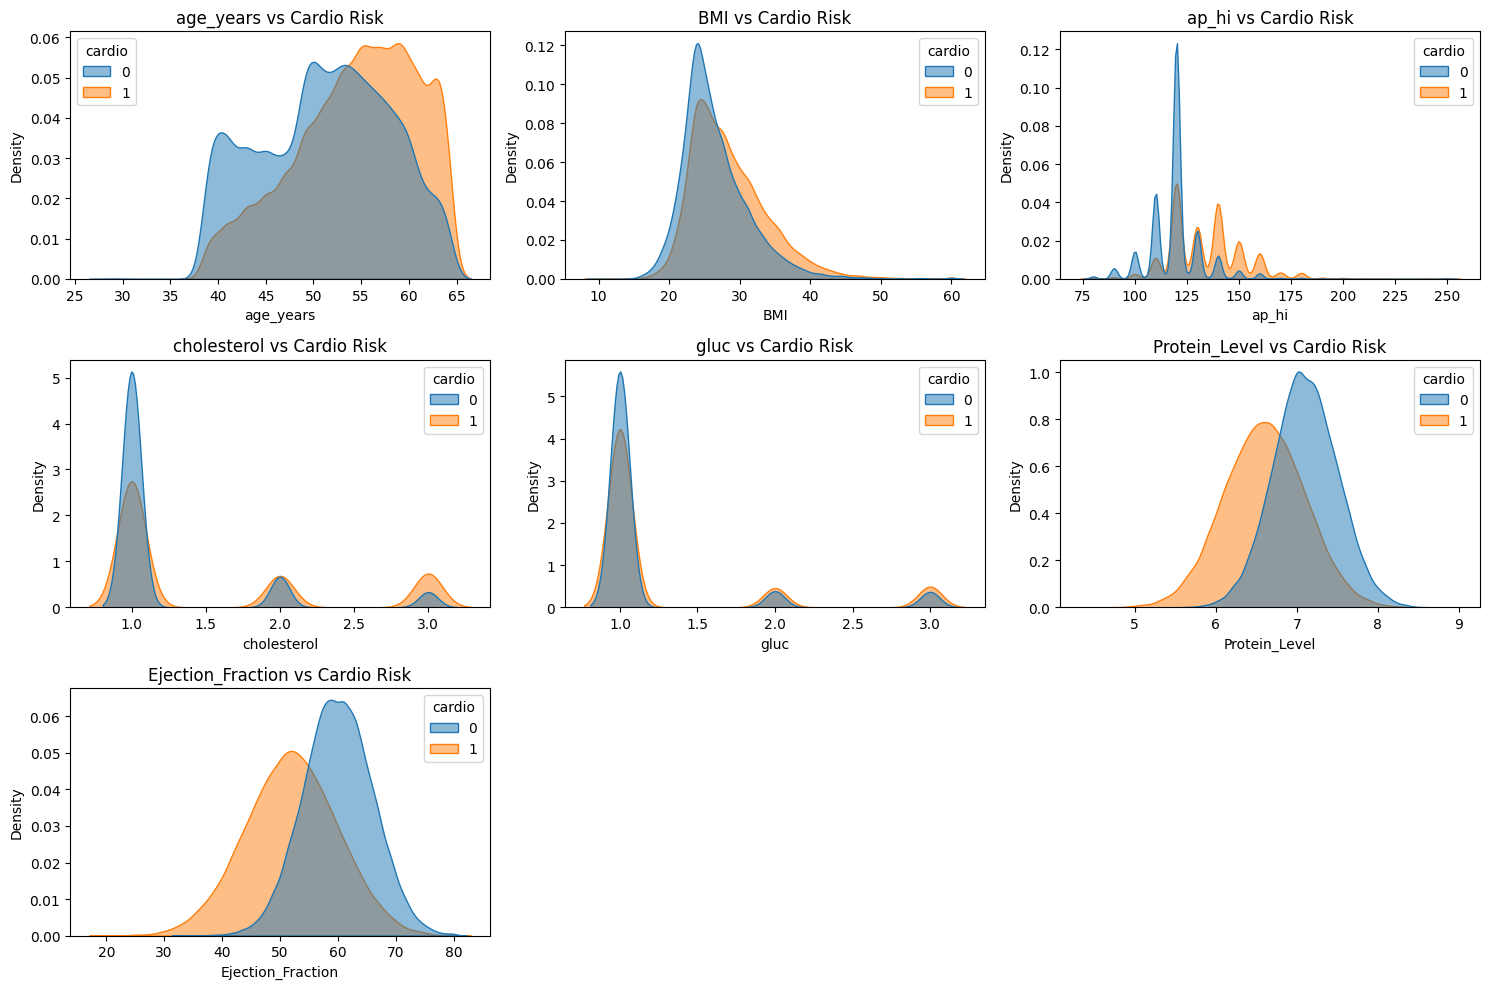

In [ ]:

features_to_plot = ['age_years', 'BMI', 'ap_hi', 'cholesterol', 'gluc', 'Protein_Level', 'Ejection_Fraction']

plt.figure(figsize=(15,10))
for i, feat in enumerate(features_to_plot, 1):
    plt.subplot(3,3,i)
    sns.kdeplot(data=df, x=feat, hue='cardio', common_norm=False, fill=True, alpha=0.5)
    plt.title(f"{feat} vs Cardio Risk")
plt.tight_layout()
plt.show()

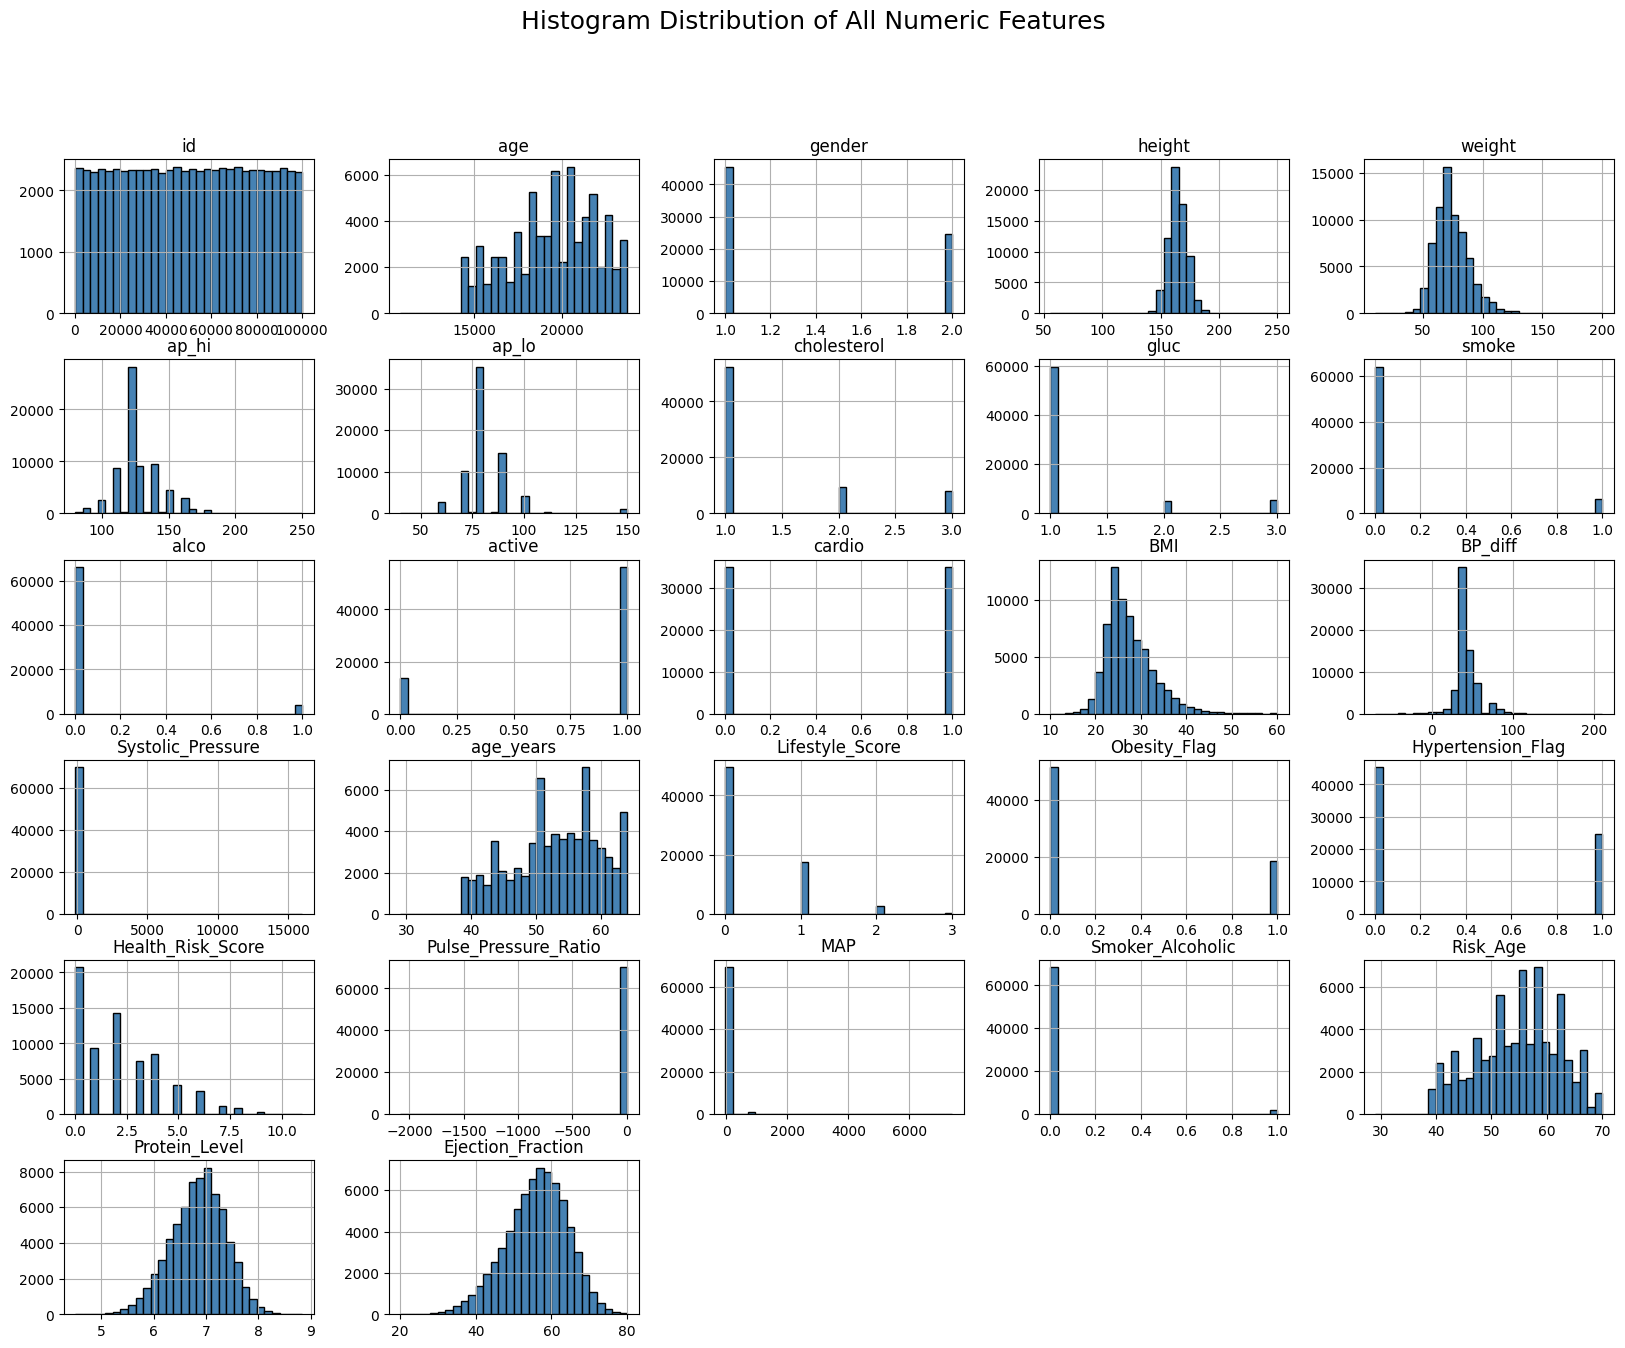

In [ ]:

numeric_cols = df.select_dtypes(include=['number']).columns

df[numeric_cols].hist(figsize=(20,15), bins=30, color='steelblue', edgecolor='black')
plt.suptitle("Histogram Distribution of All Numeric Features", fontsize=18)
plt.show()

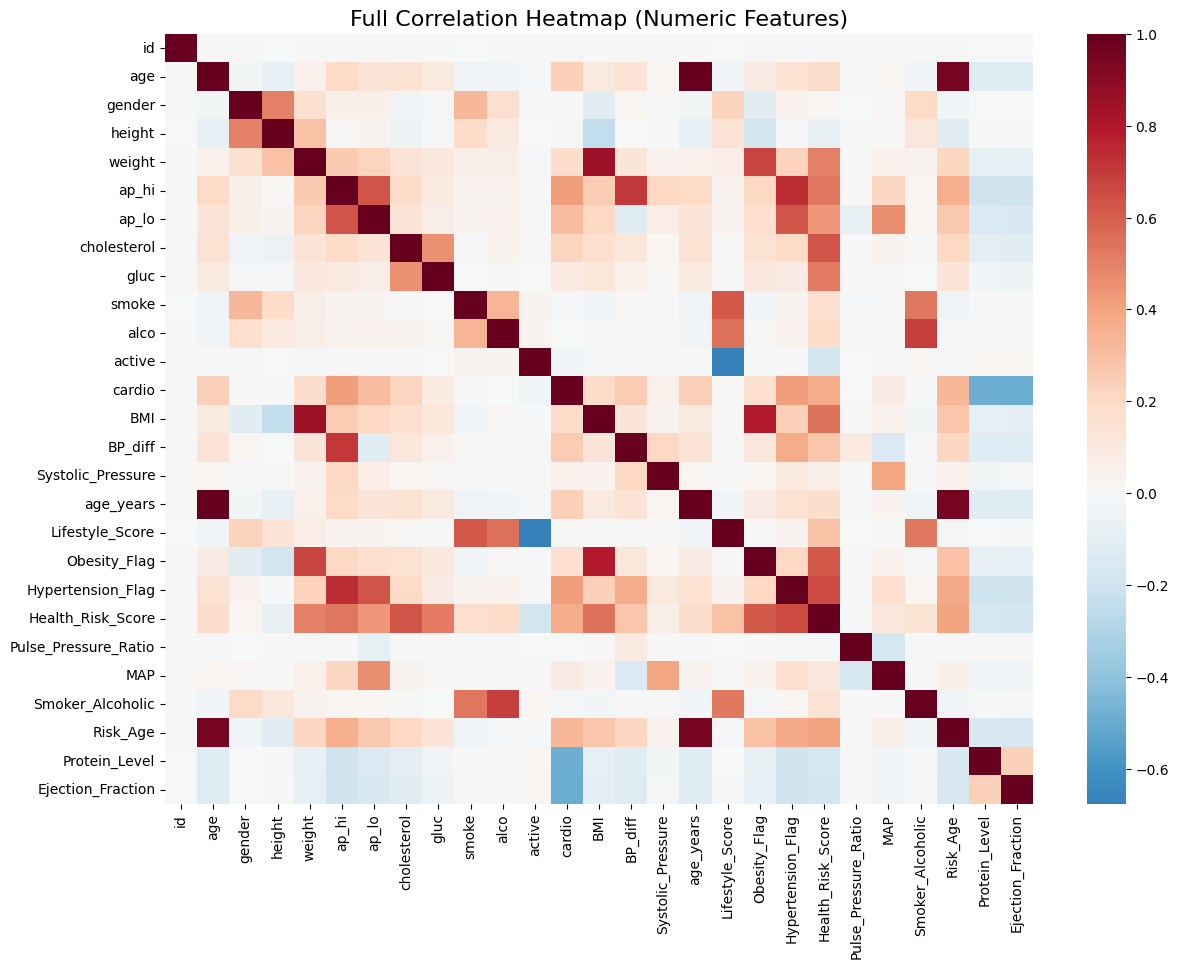

In [ ]:

plt.figure(figsize=(14,10))
sns.heatmap(df[numeric_cols].corr(), cmap='RdBu_r', center=0, annot=False)
plt.title("Full Correlation Heatmap (Numeric Features)", fontsize=16)
plt.show()

/tmp/ipython-input-4276038296.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_target.values, y=corr_target.index, palette='coolwarm')


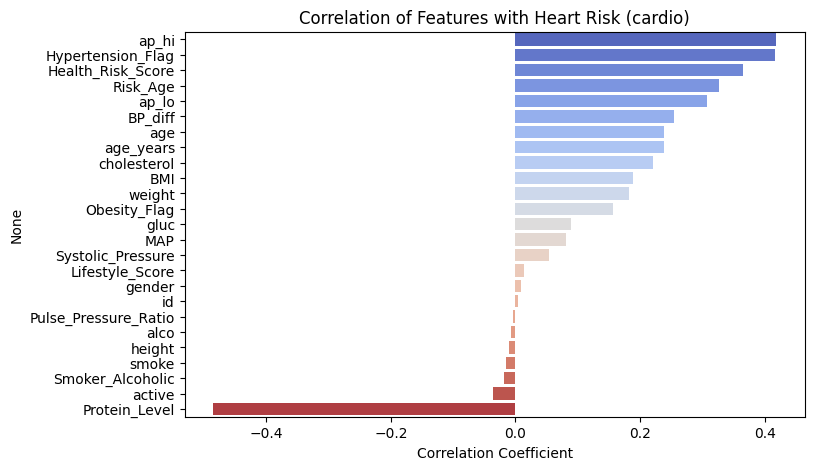

In [ ]:

corr_target = df[numeric_cols].corr()['cardio'].sort_values(ascending=False)[1:-1]
plt.figure(figsize=(8,5))
sns.barplot(x=corr_target.values, y=corr_target.index, palette='coolwarm')
plt.title("Correlation of Features with Heart Risk (cardio)")
plt.xlabel("Correlation Coefficient")
plt.show()

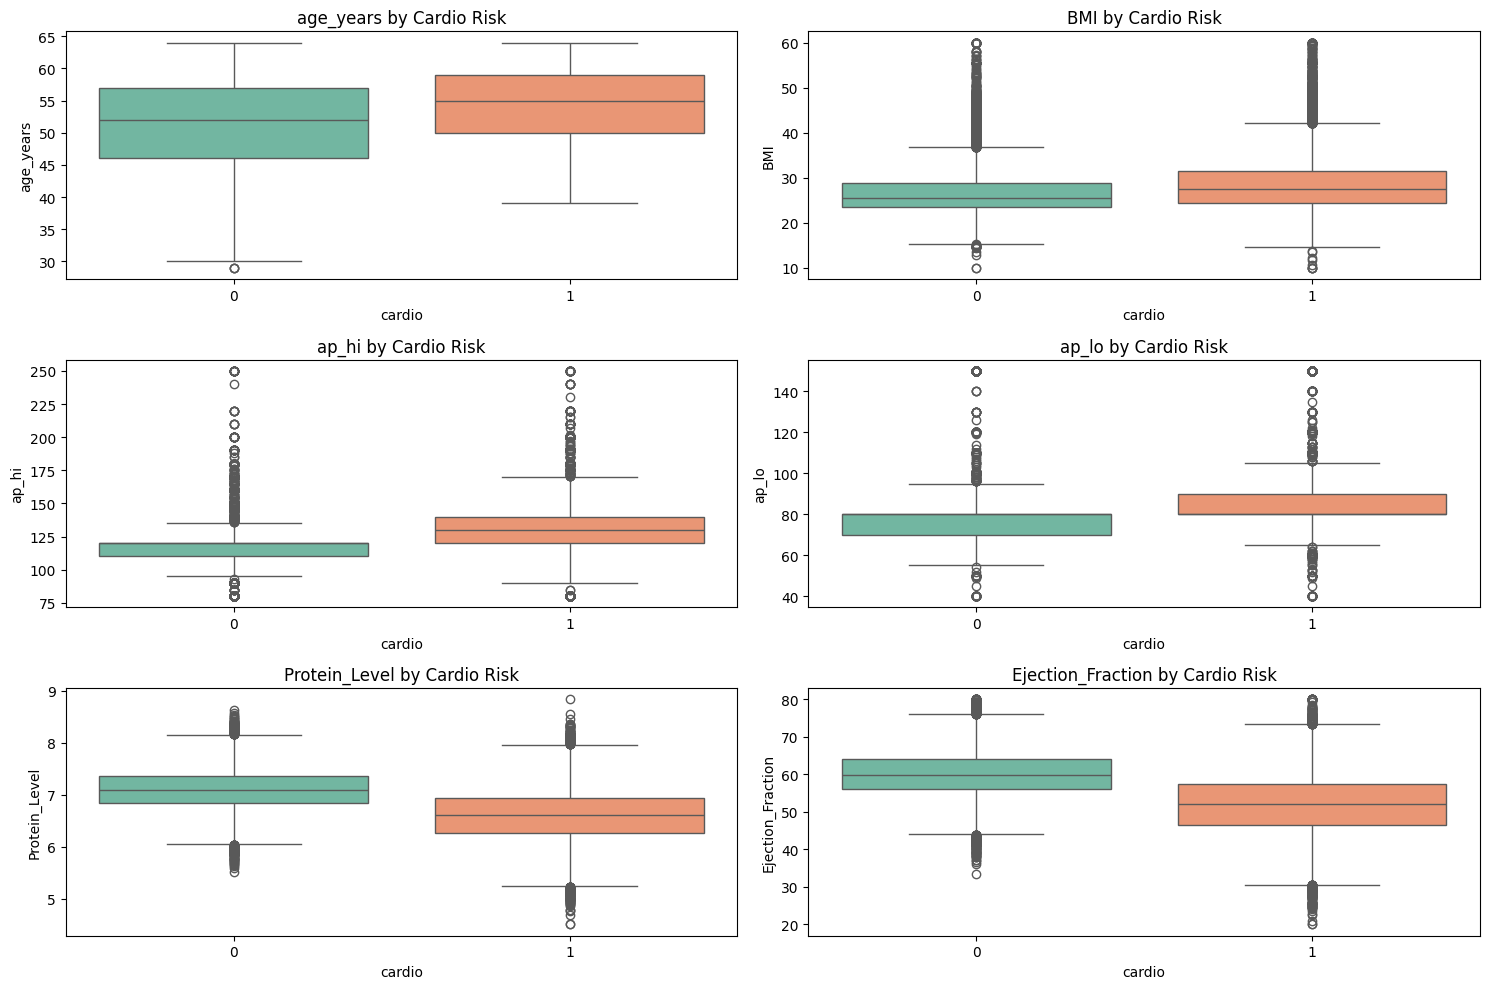

In [ ]:

features = ['age_years', 'BMI', 'ap_hi', 'ap_lo', 'Protein_Level', 'Ejection_Fraction']
plt.figure(figsize=(15,10))
for i, feat in enumerate(features, 1):
    plt.subplot(3,2,i)
    sns.boxplot(x='cardio', y=feat, data=df, palette='Set2', hue='cardio', legend=False)
    plt.title(f'{feat} by Cardio Risk')
plt.tight_layout()
plt.show()

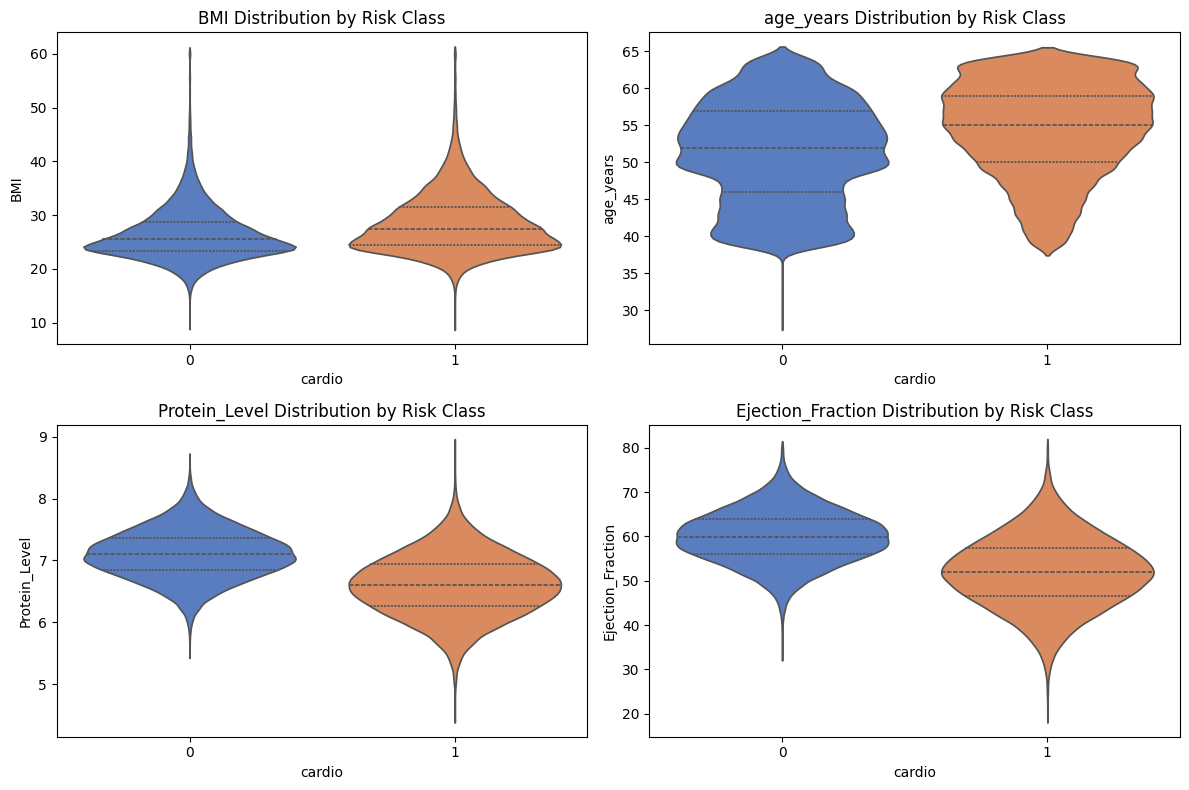

In [ ]:

violin_feats = ['BMI', 'age_years', 'Protein_Level', 'Ejection_Fraction']
plt.figure(figsize=(12,8))
for i, f in enumerate(violin_feats,1):
    plt.subplot(2,2,i)
    sns.violinplot(x='cardio', y=f, data=df, palette='muted', inner='quart', hue='cardio', legend=False)
    plt.title(f'{f} Distribution by Risk Class')
plt.tight_layout()
plt.show()

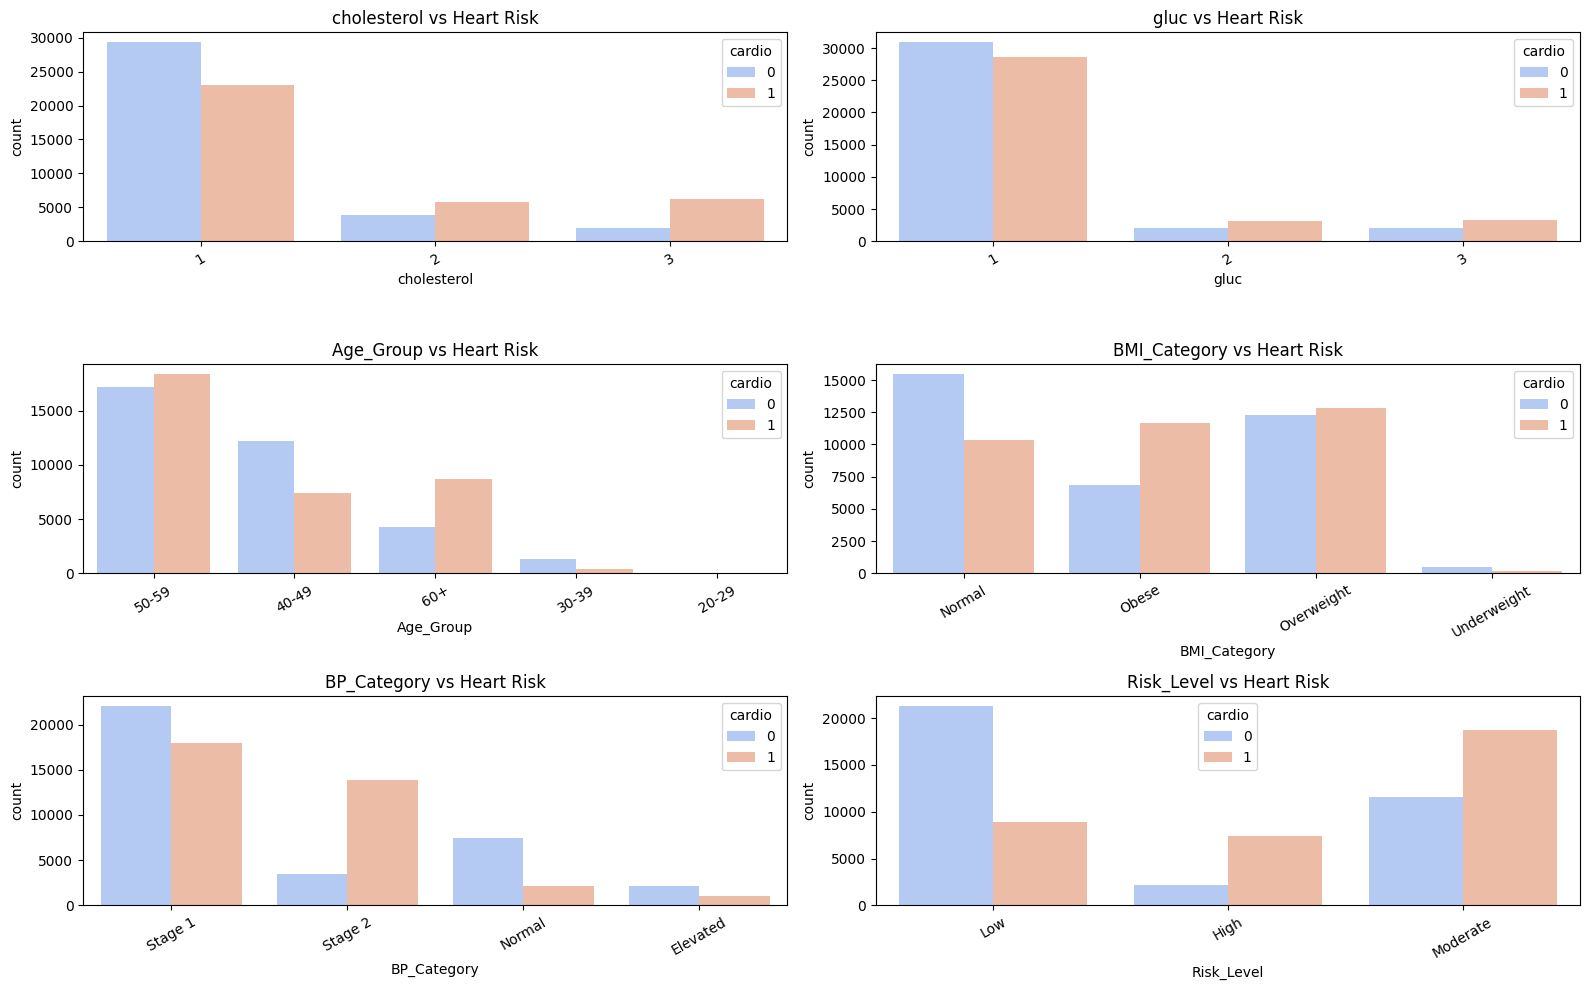

In [ ]:

cat_cols = ['cholesterol', 'gluc', 'Age_Group', 'BMI_Category', 'BP_Category', 'Risk_Level']
plt.figure(figsize=(16,10))
for i, col in enumerate(cat_cols,1):
    plt.subplot(3,2,i)
    sns.countplot(x=col, hue='cardio', data=df, palette='coolwarm')
    plt.title(f'{col} vs Heart Risk')
    plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

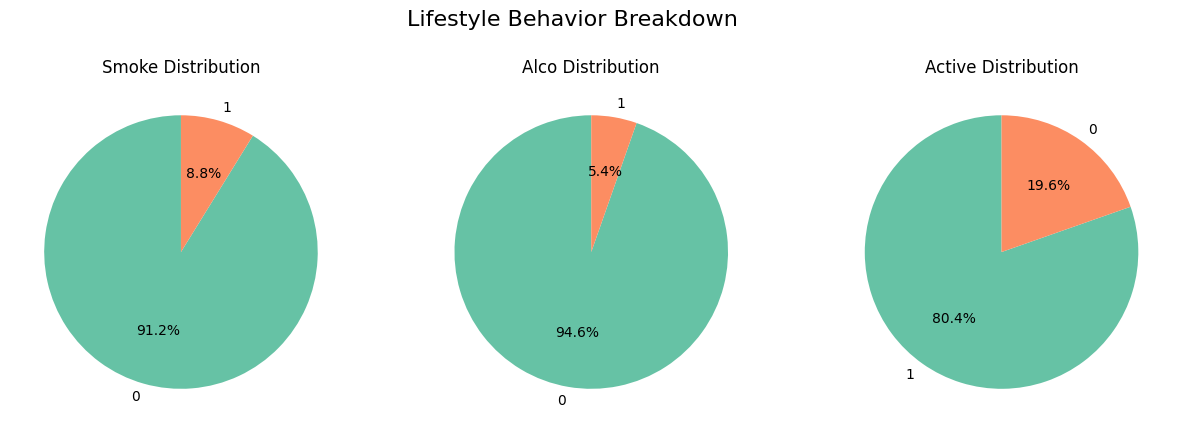

In [ ]:

fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, col in enumerate(['smoke','alco','active']):
    data = df[col].value_counts()
    ax[i].pie(data, labels=data.index, autopct='%1.1f%%', startangle=90,
              colors=sns.color_palette('Set2'))
    ax[i].set_title(f'{col.capitalize()} Distribution')
plt.suptitle("Lifestyle Behavior Breakdown", fontsize=16)
plt.show()

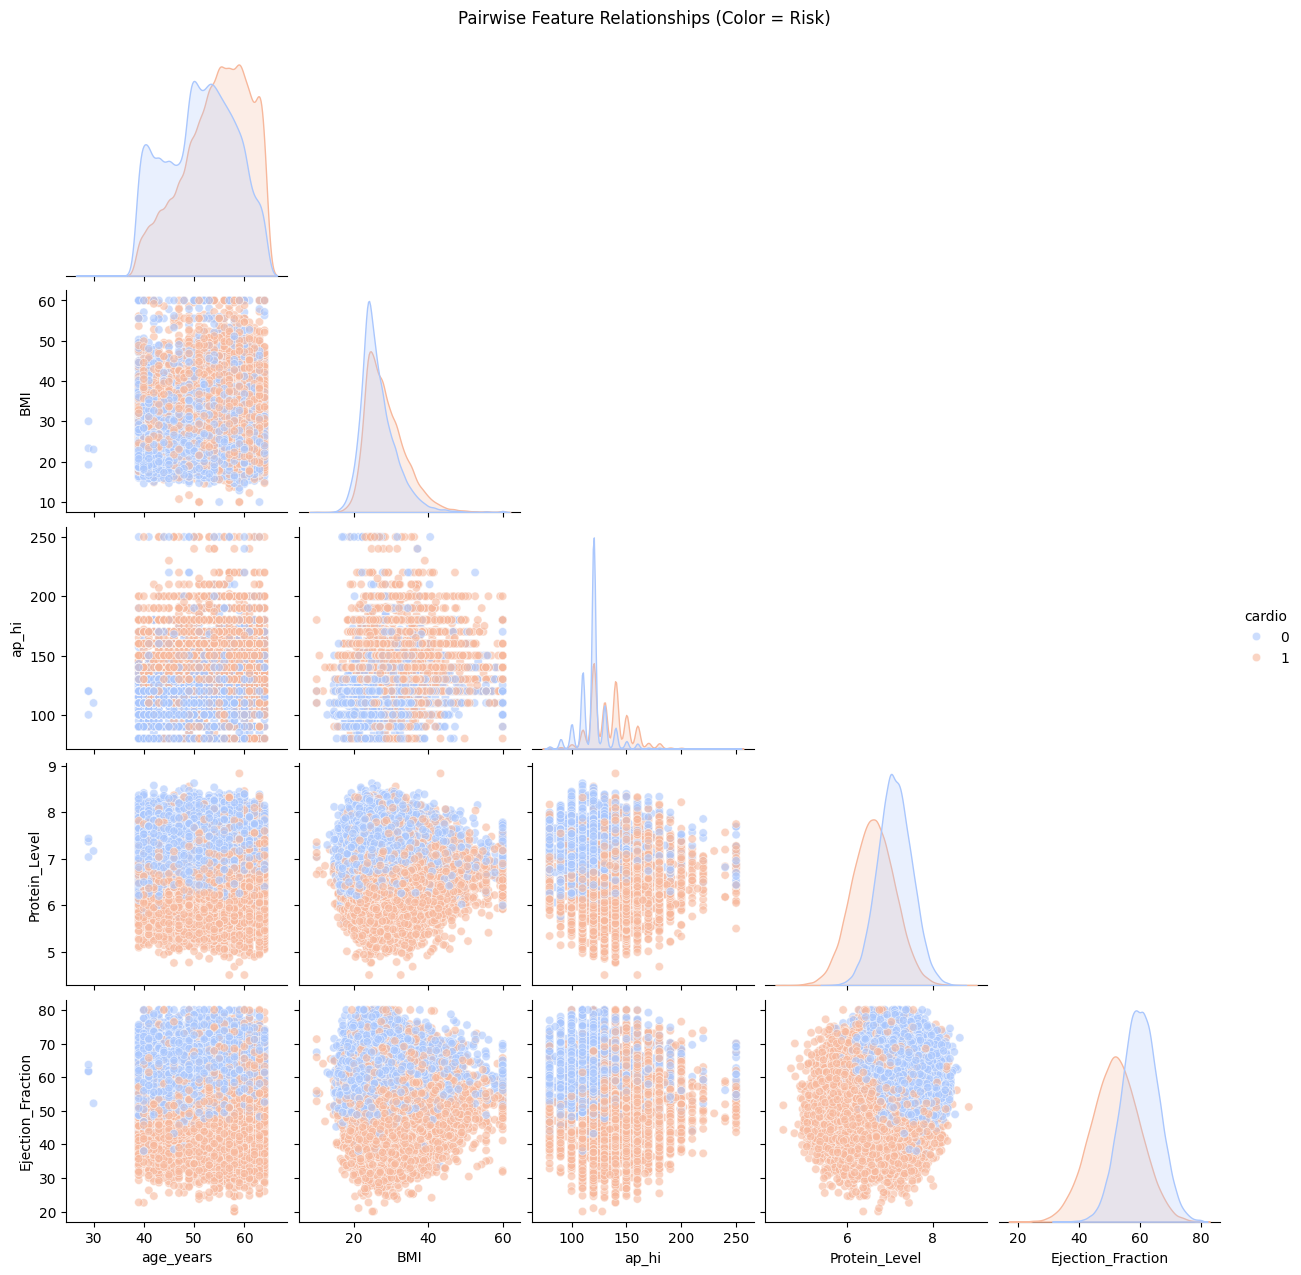

In [ ]:

sns.pairplot(df[['age_years','BMI','ap_hi','Protein_Level','Ejection_Fraction','cardio']],
             hue='cardio', palette='coolwarm', corner=True, plot_kws={'alpha':0.6})
plt.suptitle("Pairwise Feature Relationships (Color = Risk)", y=1.02)
plt.show()

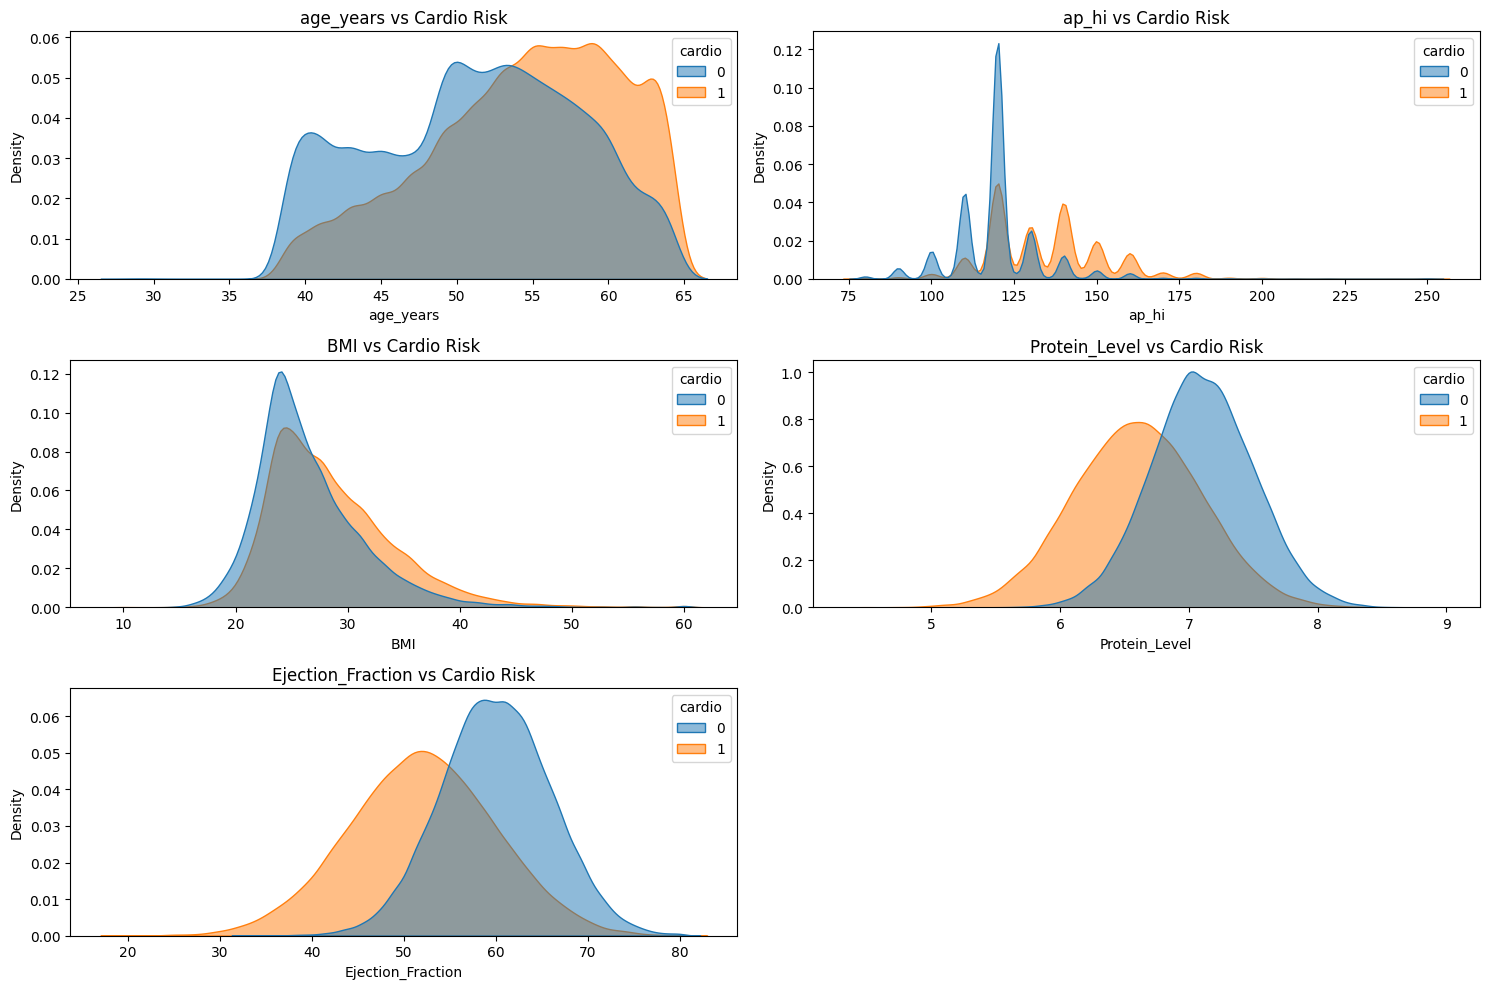

In [ ]:

feat_list = ['age_years','ap_hi','BMI','Protein_Level','Ejection_Fraction']
plt.figure(figsize=(15,10))
for i, f in enumerate(feat_list,1):
    plt.subplot(3,2,i)
    sns.kdeplot(data=df, x=f, hue='cardio', common_norm=False, fill=True, alpha=0.5)
    plt.title(f'{f} vs Cardio Risk')
plt.tight_layout()
plt.show()

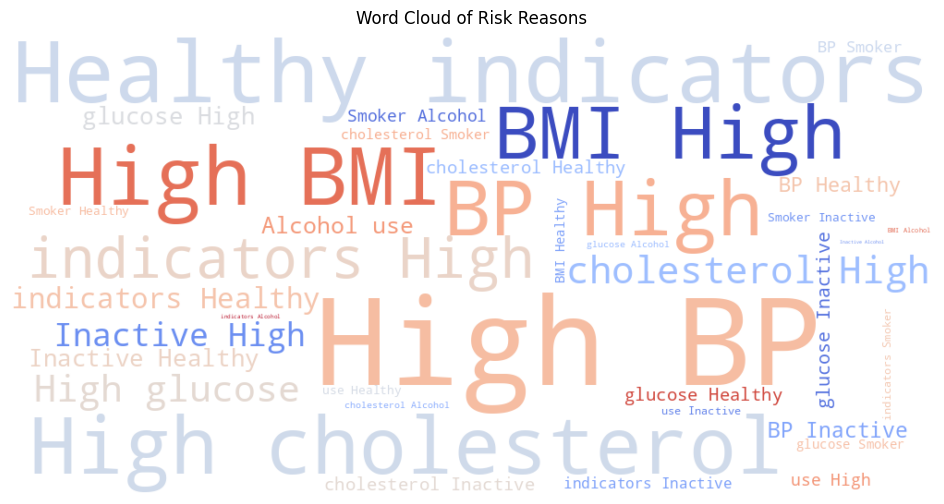

In [ ]:

!pip install wordcloud > /dev/null
from wordcloud import WordCloud

text = " ".join(df['Reason'].astype(str))
wc = WordCloud(width=1000, height=500, background_color='white', colormap='coolwarm').generate(text)

plt.figure(figsize=(14,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Risk Reasons')
plt.show()

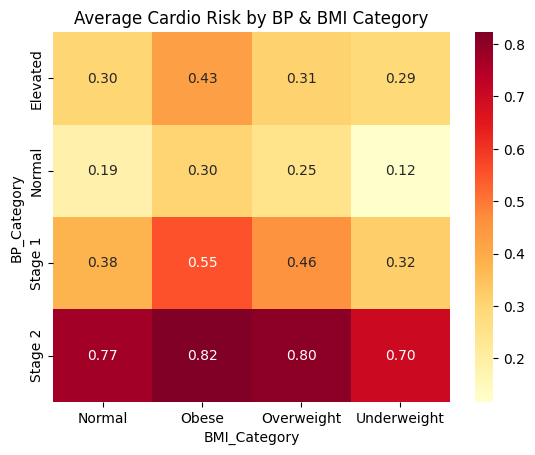

In [ ]:

risk_matrix = pd.crosstab(df['BP_Category'], df['BMI_Category'], values=df['cardio'], aggfunc='mean')
sns.heatmap(risk_matrix, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Average Cardio Risk by BP & BMI Category')
plt.show()

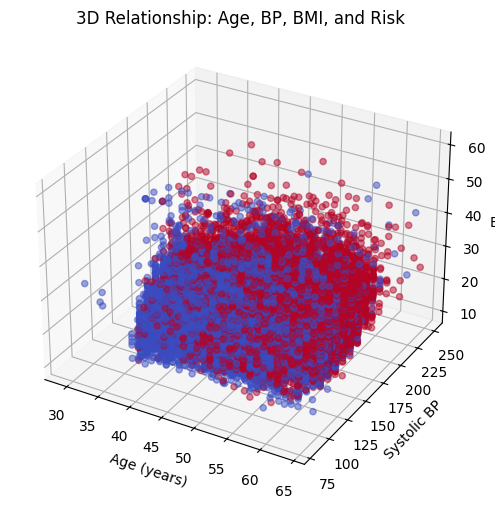

In [ ]:

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['age_years'], df['ap_hi'], df['BMI'],
           c=df['cardio'], cmap='coolwarm', alpha=0.5)
ax.set_xlabel('Age (years)')
ax.set_ylabel('Systolic BP')
ax.set_zlabel('BMI')
ax.set_title('3D Relationship: Age, BP, BMI, and Risk')
plt.show()

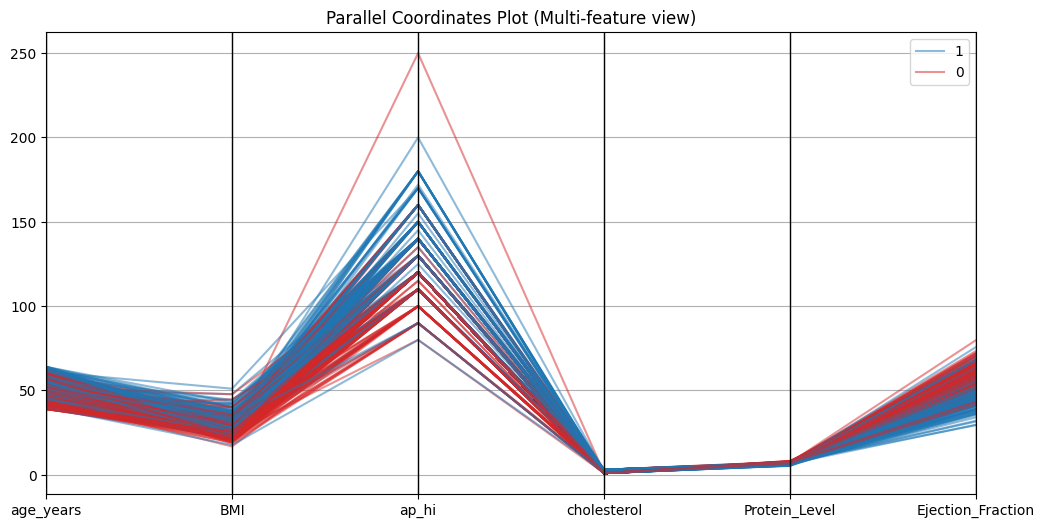

In [ ]:

from pandas.plotting import parallel_coordinates
cols = ['age_years','BMI','ap_hi','cholesterol','Protein_Level','Ejection_Fraction','cardio']
plt.figure(figsize=(12,6))
parallel_coordinates(df[cols].sample(500), class_column='cardio', color=['#1f77b4','#d62728'], alpha=0.5)
plt.title('Parallel Coordinates Plot (Multi-feature view)')
plt.show()

In [ ]:

plt.savefig("feature_relationships_heatmap.png", dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [ ]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


num_cols = [c for c in df.select_dtypes(include='number').columns if c not in ['id','cardio']]
X_num = df[num_cols].copy()
y = df['cardio']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

print("Scaled shape:", X_scaled.shape)

Scaled shape: (70000, 25)


Explained variance (2D): 31.85 %


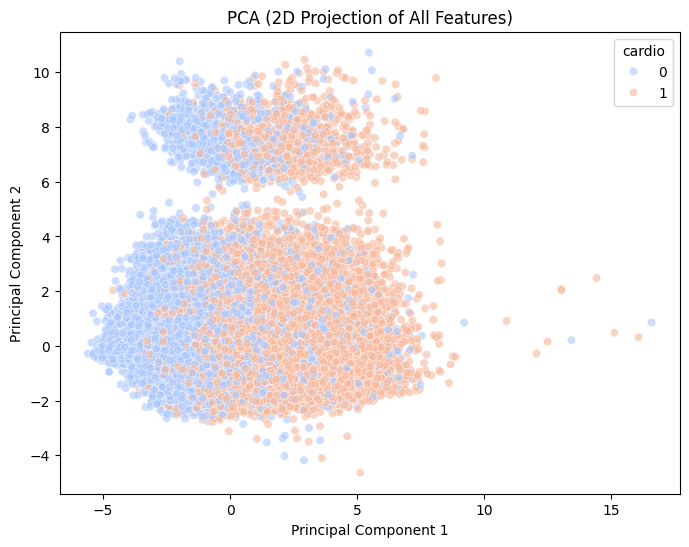

In [ ]:

pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_scaled)

print("Explained variance (2D):", round(sum(pca_2d.explained_variance_ratio_)*100, 2), "%")

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca_2d[:,0], y=X_pca_2d[:,1], hue=y, palette='coolwarm', alpha=0.6)
plt.title("PCA (2D Projection of All Features)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

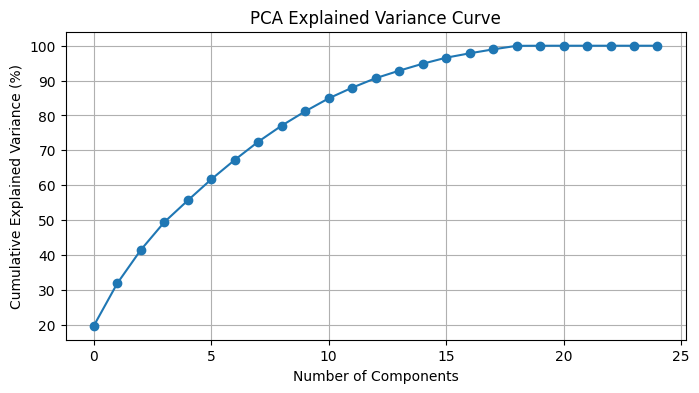

In [ ]:

pca_full = PCA().fit(X_scaled)
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_)*100, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('PCA Explained Variance Curve')
plt.grid(True)
plt.show()

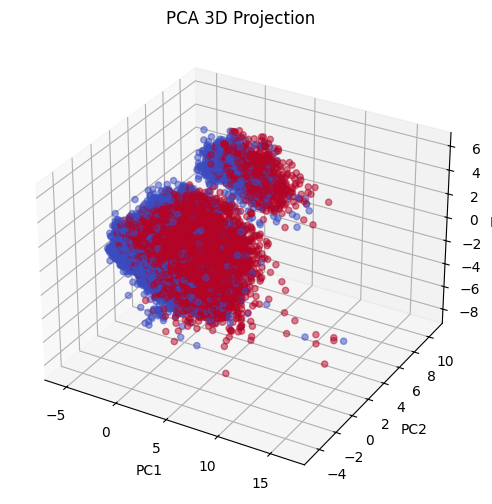

In [ ]:

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_3d[:,0], X_pca_3d[:,1], X_pca_3d[:,2],
           c=y, cmap='coolwarm', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA 3D Projection')
plt.show()

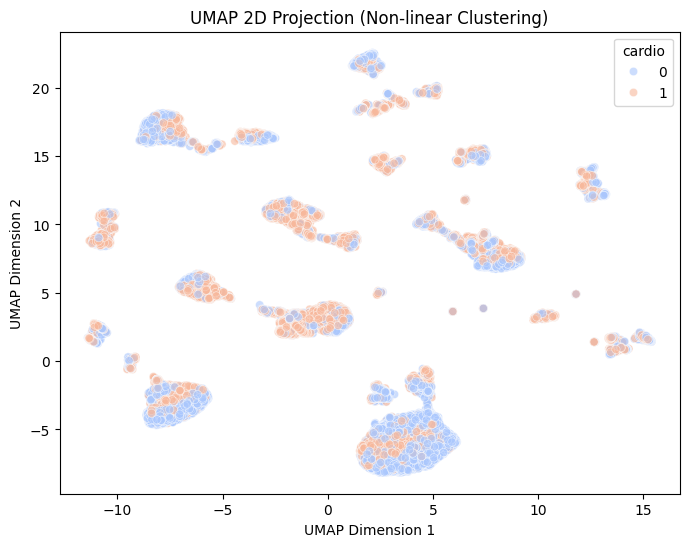

In [ ]:

!pip install umap-learn > /dev/null
import umap.umap_ as umap

umap_2d = umap.UMAP(n_neighbors=30, min_dist=0.1)
X_umap = umap_2d.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=y, palette='coolwarm', alpha=0.6)
plt.title("UMAP 2D Projection (Non-linear Clustering)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

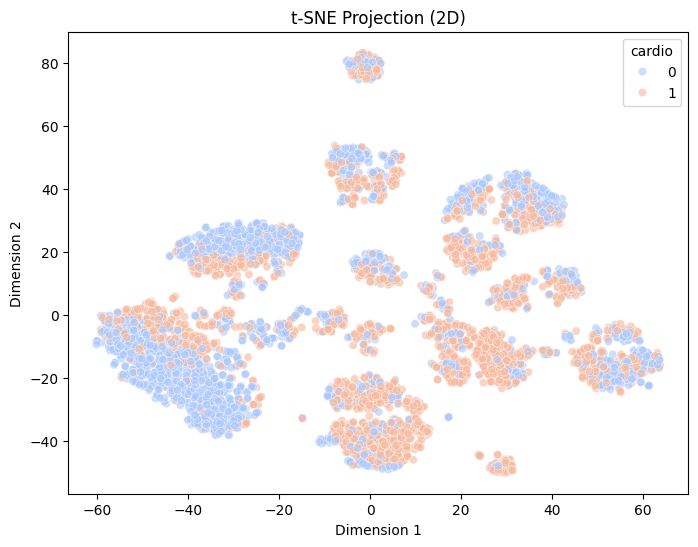

In [ ]:

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_scaled[:5000])  # use subset for speed

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y[:5000], palette='coolwarm', alpha=0.6)
plt.title("t-SNE Projection (2D)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

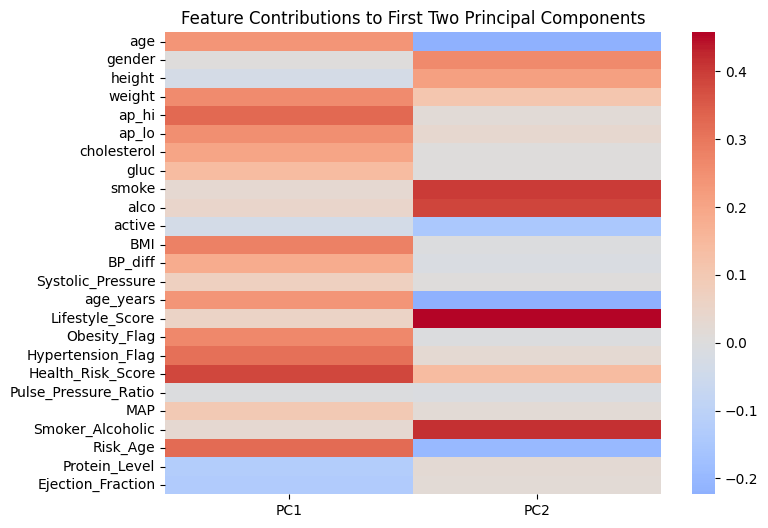

Health_Risk_Score    0.382901
ap_hi                0.326046
Risk_Age             0.323984
Hypertension_Flag    0.312739
BMI                  0.280869
Obesity_Flag         0.265352
weight               0.260549
ap_lo                0.252332
age                  0.236449
age_years            0.236379
Name: PC1, dtype: float64

Lifestyle_Score     0.457493
Smoker_Alcoholic    0.412343
smoke               0.401631
alco                0.385864
gender              0.261525
age_years           0.223304
age                 0.223204
height              0.212252
Risk_Age            0.199325
active              0.147921
Name: PC2, dtype: float64

In [ ]:

loadings = pd.DataFrame(pca_2d.components_.T, columns=['PC1','PC2'], index=num_cols)
plt.figure(figsize=(8,6))
sns.heatmap(loadings, cmap='coolwarm', center=0)
plt.title('Feature Contributions to First Two Principal Components')
plt.show()


top_pc1 = loadings['PC1'].abs().sort_values(ascending=False).head(10)
top_pc2 = loadings['PC2'].abs().sort_values(ascending=False).head(10)
display(top_pc1, top_pc2)

In [ ]:

pca_df = pd.DataFrame(X_pca_2d, columns=['PC1','PC2'])
pca_df['cardio'] = y.values
pca_df.to_csv('pca_projection.csv', index=False)

umap_df = pd.DataFrame(X_umap, columns=['UMAP1','UMAP2'])
umap_df['cardio'] = y.values
umap_df.to_csv('umap_projection.csv', index=False)

print("Saved PCA and UMAP projections to CSV.")

Saved PCA and UMAP projections to CSV.


In [ ]:

!pip install --upgrade xgboost catboost lightgbm shap matplotlib seaborn joblib

In [ ]:

!pip install --upgrade xgboost catboost lightgbm shap matplotlib seaborn joblib

In [ ]:

!pip install --upgrade xgboost catboost lightgbm shap matplotlib seaborn joblib

In [ ]:

!pip install -U scikit-learn
!pip install --upgrade xgboost catboost lightgbm shap matplotlib seaborn joblib umap-learn mlxtend


In [ ]:

import os, sys, joblib
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from time import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)

RND = 42
DATA_PATH = "/content/cardio_train_extended.csv"
RESULTS_DIR = "/content/model_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [ ]:

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)

drop_cols = ['id','age','Reason'] if set(['id','age','Reason']).issubset(df.columns) else ['id','age']
X = df.drop(columns=drop_cols + ['cardio'])
y = df['cardio']

cat_cols = [c for c in X.columns if X[c].dtype == 'object' or X[c].dtype.name == 'category']
num_cols = [c for c in X.columns if c not in cat_cols]
print("Num cols:", len(num_cols), "Cat cols:", len(cat_cols))

Shape: (70000, 32)
Num cols: 24 Cat cols: 4


In [ ]:

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RND, stratify=y
)
print("Train:", X_train_raw.shape, "Test:", X_test_raw.shape)

Train: (56000, 28) Test: (14000, 28)


In [ ]:

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')

# Fit on train and transform both
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

# Build processed feature names list
ohe_names = []
if cat_cols:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    ohe_names = list(ohe.get_feature_names_out(cat_cols))
processed_feature_names = num_cols + ohe_names
print("Processed features:", len(processed_feature_names))

Processed features: 40


In [ ]:
# Cell 6 - helper functions
from collections import OrderedDict
models_metrics = []

def evaluate_model(name, model, X_tr, y_tr, X_te, y_te, save_model=True):
    t0 = time()
    model.fit(X_tr, y_tr)
    fit_time = time() - t0
    preds = model.predict(X_te)
    probs = model.predict_proba(X_te)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_te)
    metrics = {
        "model": name,
        "accuracy": accuracy_score(y_te, preds),
        "precision": precision_score(y_te, preds),
        "recall": recall_score(y_te, preds),
        "f1": f1_score(y_te, preds),
        "roc_auc": roc_auc_score(y_te, probs),
        "fit_time_sec": fit_time
    }
    models_metrics.append(metrics)
    print(f"\n== {name} ==\n", pd.Series(metrics).to_frame(name).T)
    print(classification_report(y_te, preds, digits=4))
    if save_model:
        joblib.dump(model, os.path.join(RESULTS_DIR, f"{name}.joblib"))
    return model, preds, probs

In [ ]:
# Cell 7 - Logistic Regression
lr = LogisticRegression(max_iter=2000, random_state=RND)
lr_model, lr_preds, lr_probs = evaluate_model("LogisticRegression", lr, X_train, y_train, X_test, y_test)


== LogisticRegression ==
                                  model  accuracy precision    recall  \
LogisticRegression  LogisticRegression  0.838929  0.840736  0.836049   

                          f1   roc_auc fit_time_sec  
LogisticRegression  0.838386  0.914527     0.361435  
              precision    recall  f1-score   support

           0     0.8371    0.8418    0.8395      7004
           1     0.8407    0.8360    0.8384      6996

    accuracy                         0.8389     14000
   macro avg     0.8389    0.8389    0.8389     14000
weighted avg     0.8389    0.8389    0.8389     14000



In [ ]:
# Cell 8 - Random Forest (reasonable defaults, fast)
rf = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=RND, n_jobs=1)
rf_model, rf_preds, rf_probs = evaluate_model("RandomForest", rf, X_train, y_train, X_test, y_test)


== RandomForest ==
                      model  accuracy precision    recall       f1   roc_auc  \
RandomForest  RandomForest  0.846714  0.849424  0.842624  0.84601  0.918221   

             fit_time_sec  
RandomForest    16.860125  
              precision    recall  f1-score   support

           0     0.8441    0.8508    0.8474      7004
           1     0.8494    0.8426    0.8460      6996

    accuracy                         0.8467     14000
   macro avg     0.8467    0.8467    0.8467     14000
weighted avg     0.8467    0.8467    0.8467     14000



In [ ]:
# Cell 9 - XGBoost
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(
    n_estimators=300, learning_rate=0.08, max_depth=6,
    eval_metric='logloss', random_state=RND, n_jobs=1
)
xgb_model, xgb_preds, xgb_probs = evaluate_model("XGBoost", xgb_clf, X_train, y_train, X_test, y_test)


== XGBoost ==
            model  accuracy precision    recall        f1  roc_auc fit_time_sec
XGBoost  XGBoost  0.848214  0.853843  0.840051  0.846891  0.92293     4.566297
              precision    recall  f1-score   support

           0     0.8428    0.8564    0.8495      7004
           1     0.8538    0.8401    0.8469      6996

    accuracy                         0.8482     14000
   macro avg     0.8483    0.8482    0.8482     14000
weighted avg     0.8483    0.8482    0.8482     14000



In [ ]:
# Cell 10 - CatBoost (works on numpy arrays too)
from catboost import CatBoostClassifier
cb = CatBoostClassifier(iterations=600, depth=6, learning_rate=0.05, random_seed=RND, verbose=0)
cb_model, cb_preds, cb_probs = evaluate_model("CatBoost", cb, X_train, y_train, X_test, y_test)


== CatBoost ==
              model accuracy precision    recall        f1   roc_auc  \
CatBoost  CatBoost   0.8495  0.855667  0.840623  0.848078  0.924751   

         fit_time_sec  
CatBoost    21.431641  
              precision    recall  f1-score   support

           0     0.8436    0.8584    0.8509      7004
           1     0.8557    0.8406    0.8481      6996

    accuracy                         0.8495     14000
   macro avg     0.8496    0.8495    0.8495     14000
weighted avg     0.8496    0.8495    0.8495     14000



In [ ]:
# Cell 11 - LightGBM
import lightgbm as lgb
lgb_clf = lgb.LGBMClassifier(n_estimators=400, learning_rate=0.06, max_depth=8, random_state=RND, n_jobs=1)
lgb_model, lgb_preds, lgb_probs = evaluate_model("LightGBM", lgb_clf, X_train, y_train, X_test, y_test)

[LightGBM] [Info] Number of positive: 27983, number of negative: 28017
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2061
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499696 -> initscore=-0.001214
[LightGBM] [Info] Start training from score -0.001214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



== LightGBM ==
              model  accuracy precision    recall        f1   roc_auc  \
LightGBM  LightGBM  0.848857  0.854754  0.840337  0.847485  0.923164   

         fit_time_sec  
LightGBM     3.221709  
              precision    recall  f1-score   support

           0     0.8432    0.8574    0.8502      7004
           1     0.8548    0.8403    0.8475      6996

    accuracy                         0.8489     14000
   macro avg     0.8490    0.8489    0.8488     14000
weighted avg     0.8490    0.8489    0.8488     14000



In [ ]:
# Cell 13 - aggregate & display
metrics_df = pd.DataFrame(models_metrics)
# Order columns
metrics_df = metrics_df[['model','accuracy','precision','recall','f1','roc_auc','fit_time_sec']]
# Save & display
metrics_df.to_csv(os.path.join(RESULTS_DIR, "model_metrics_summary.csv"), index=False)
# Sort by recall (our priority) then accuracy
metrics_df_sorted = metrics_df.sort_values(by=['recall','accuracy'], ascending=False).reset_index(drop=True)
display(metrics_df_sorted)

model  accuracy  precision    recall        f1   roc_auc  \
0        RandomForest  0.846714   0.849424  0.842624  0.846010  0.918221   
1            CatBoost  0.849500   0.855667  0.840623  0.848078  0.924751   
2            LightGBM  0.848857   0.854754  0.840337  0.847485  0.923164   
3             XGBoost  0.848214   0.853843  0.840051  0.846891  0.922930   
4             XGBoost  0.848214   0.853843  0.840051  0.846891  0.922930   
5  LogisticRegression  0.838929   0.840736  0.836049  0.838386  0.914527   

   fit_time_sec  
0     16.860125  
1     21.431641  
2      3.221709  
3      5.354553  
4      4.566297  
5      0.361435

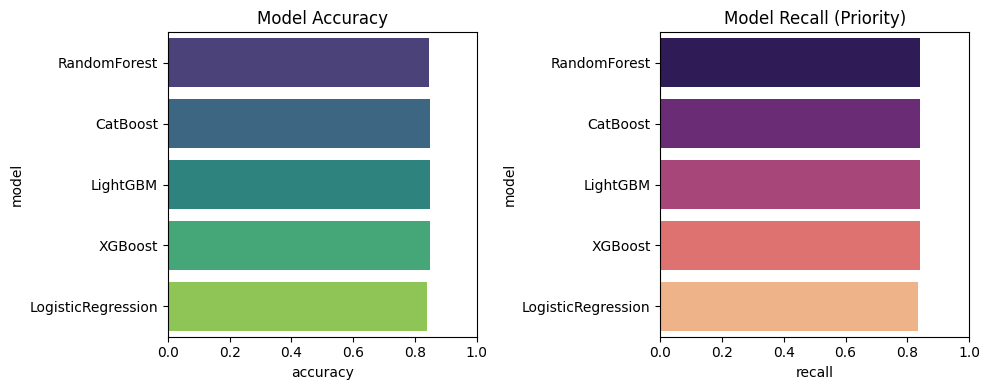

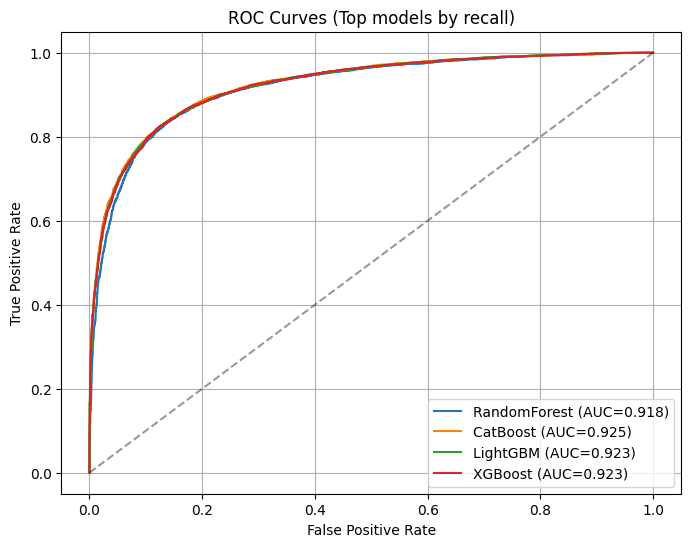

In [ ]:
# Cell 14 - plots: accuracy & recall
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.barplot(x='accuracy', y='model', data=metrics_df_sorted, palette='viridis', hue='model', legend=False)
plt.title("Model Accuracy")
plt.xlim(0,1)
plt.subplot(1,2,2)
sns.barplot(x='recall', y='model', data=metrics_df_sorted, palette='magma', hue='model', legend=False)
plt.title("Model Recall (Priority)")
plt.xlim(0,1)
plt.tight_layout()
plt.show()

# ROC curves for top 4 models by recall
top4 = metrics_df_sorted['model'].head(4).tolist()
plt.figure(figsize=(8,6))
for m in top4:
    mod = joblib.load(os.path.join(RESULTS_DIR, f"{m}.joblib"))
    probs = None
    # load probs from memory variables if present
    if m == "LogisticRegression":
        probs = lr_probs
    elif m == "RandomForest":
        probs = rf_probs
    elif m == "XGBoost":
        probs = xgb_probs
    elif m == "CatBoost":
        probs = cb_probs
    elif m == "LightGBM":
        probs = lgb_probs
    else:
        # try model.predict_proba
        try:
            probs = mod.predict_proba(X_test)[:,1]
        except:
            continue
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{m} (AUC={roc_auc_score(y_test, probs):.3f})")
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Top models by recall)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Cell 15 - save summary and note next steps
print("Saved model artifacts to:", RESULTS_DIR)
print("Metrics saved to:", os.path.join(RESULTS_DIR, "model_metrics_summary.csv"))
# Next steps recommendation:
print("""
Next steps (recommended):
1) Inspect metrics_df_sorted above and pick 2-3 top models (e.g., best recall, best AUC).
2) Run calibration (Isotonic or Platt) on those models if you want reliable probabilities.
3) Generate SHAP for the best model(s) for feature importance and sample explainability (I will provide cells).
4) If you want, we can run Optuna tuning on XGB/CAT to push recall/accuracy further.
""")

Saved model artifacts to: /content/model_results
Metrics saved to: /content/model_results/model_metrics_summary.csv

Next steps (recommended):
1) Inspect metrics_df_sorted above and pick 2-3 top models (e.g., best recall, best AUC).
2) Run calibration (Isotonic or Platt) on those models if you want reliable probabilities.
3) Generate SHAP for the best model(s) for feature importance and sample explainability (I will provide cells).
4) If you want, we can run Optuna tuning on XGB/CAT to push recall/accuracy further.



In [ ]:
# Cell 1 - load / prepare holdout probabilities
import os, joblib, numpy as np, pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

RESULTS_DIR = "/content/model_results"  # adjust if different
HOLDOUT_BASE_PROBS = os.path.join(RESULTS_DIR, "holdout_base_probs.csv")

# Try to use in-memory variables if they exist (from prior cells)
try:
    p_xgb = xgb_probs  # variable name used earlier in your session
    p_cat = cb_probs
    print("Using in-memory probability arrays (xgb_probs, cb_probs).")
except Exception:
    p_xgb = None
    p_cat = None

# If not in-memory, try loading CSV
if (p_xgb is None) or (p_cat is None):
    if os.path.exists(HOLDOUT_BASE_PROBS):
        print("Loading holdout base probs from:", HOLDOUT_BASE_PROBS)
        df_hold = pd.read_csv(HOLDOUT_BASE_PROBS)
        # expected columns: test_index, y_test, p_xgb_holdout_full, p_cat_holdout_full
        # adapt to your column names if different
        col_candidates = [c for c in df_hold.columns if 'xgb' in c.lower() or 'cat' in c.lower()]
        # heuristics
        if 'p_xgb_holdout_full' in df_hold.columns:
            p_xgb = df_hold['p_xgb_holdout_full'].values
        elif any('xgb' in c.lower() for c in df_hold.columns):
            p_xgb = df_hold[[c for c in df_hold.columns if 'xgb' in c.lower()][0]].values
        if 'p_cat_holdout_full' in df_hold.columns:
            p_cat = df_hold['p_cat_holdout_full'].values
        elif any('cat' in c.lower() for c in df_hold.columns):
            p_cat = df_hold[[c for c in df_hold.columns if 'cat' in c.lower()][0]].values
        # get y_test
        if 'y_test' in df_hold.columns:
            y_test = df_hold['y_test'].values
        elif 'target' in df_hold.columns:
            y_test = df_hold['target'].values
        else:
            # fallback to in-memory y_test if available
            try:
                y_test = y_test
            except:
                raise RuntimeError("Couldn't find y_test in CSV and no in-memory y_test. Please provide y_test.")
    else:
        # fallback: try to compute probs from saved full models if X_test exists
        print("holdout_base_probs.csv not found. Attempting to compute from saved full models and X_test.")
        try:
            # load preprocessor and X_test_raw -> transform
            xgb_full = joblib.load(os.path.join(RESULTS_DIR, "XGBoost.joblib"))
            cat_full = joblib.load(os.path.join(RESULTS_DIR, "CatBoost.joblib"))
            # Expect X_test to be available in the notebook (X_test)
            X_input = X_test  # processed features matrix (numpy)
            p_xgb = xgb_full.predict_proba(X_input)[:,1]
            p_cat = cat_full.predict_proba(X_input)[:,1]
            print("Computed holdout probs from saved models.")
        except Exception as e:
            raise RuntimeError("Cannot locate probabilities or compute them. Provide holdout_base_probs.csv or have XGBoost/CatBoost models and X_test in memory.") from e

# Sanity
print("Lengths -> p_xgb:", len(p_xgb), "p_cat:", len(p_cat), "y_test:", len(y_test))

Using in-memory probability arrays (xgb_probs, cb_probs).
Lengths -> p_xgb: 14000 p_cat: 14000 y_test: 14000


In [ ]:
# Cell 2 - weighted ensemble creation & metrics
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# choose weights (change if you want to tune)
w_xgb = 0.5
w_cat = 0.5

p_weighted = w_xgb * np.array(p_xgb) + w_cat * np.array(p_cat)

# Threshold for binary prediction (standard 0.5)
thr = 0.5
pred_xgb = (np.array(p_xgb) >= thr).astype(int)
pred_cat = (np.array(p_cat) >= thr).astype(int)
pred_weighted = (p_weighted >= thr).astype(int)

def metrics(y_true, preds, probs):
    return {
        "accuracy": accuracy_score(y_true, preds),
        "precision": precision_score(y_true, preds),
        "recall": recall_score(y_true, preds),
        "f1": f1_score(y_true, preds),
        "roc_auc": roc_auc_score(y_true, probs)
    }

metrics_xgb = metrics(y_test, pred_xgb, p_xgb)
metrics_cat = metrics(y_test, pred_cat, p_cat)
metrics_weighted = metrics(y_test, pred_weighted, p_weighted)

print("=== XGBoost metrics ==="); print(pd.Series(metrics_xgb))
print("\n=== CatBoost metrics ==="); print(pd.Series(metrics_cat))
print("\n=== Weighted Ensemble ({}*XGB + {}*CAT) metrics ===".format(w_xgb, w_cat)); print(pd.Series(metrics_weighted))

# Save CSV of ensemble predictions as proof
out_df = pd.DataFrame({
    "y_test": y_test,
    "p_xgb": p_xgb,
    "p_cat": p_cat,
    "p_weighted": p_weighted,
    "pred_weighted": pred_weighted
})
out_csv = os.path.join(RESULTS_DIR, "ensemble_predictions_weighted.csv")
out_df.to_csv(out_csv, index=False)
print("\nSaved ensemble predictions to:", out_csv)

=== XGBoost metrics ===
accuracy     0.848214
precision    0.853843
recall       0.840051
f1           0.846891
roc_auc      0.922930
dtype: float64

=== CatBoost metrics ===
accuracy     0.849500
precision    0.855667
recall       0.840623
f1           0.848078
roc_auc      0.924751
dtype: float64

=== Weighted Ensemble (0.5*XGB + 0.5*CAT) metrics ===
accuracy     0.849071
precision    0.855231
recall       0.840194
f1           0.847646
roc_auc      0.924355
dtype: float64

Saved ensemble predictions to: /content/model_results/ensemble_predictions_weighted.csv


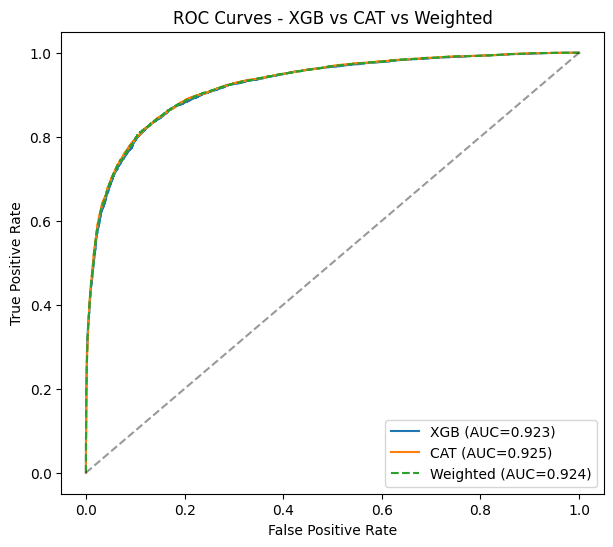

Saved ROC overlay to: /content/model_results/roc_overlay_weighted.png


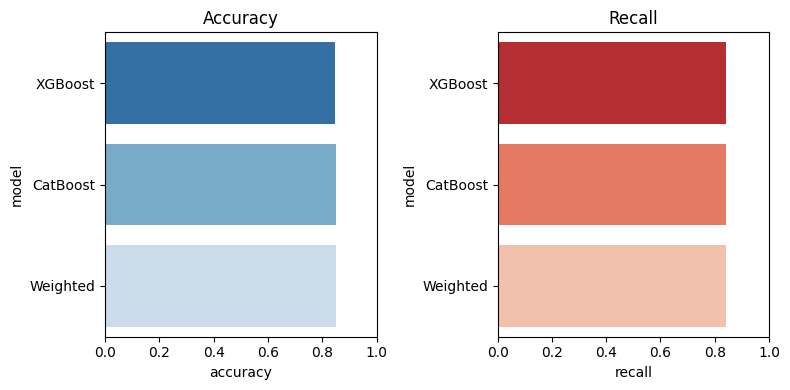

Saved comparison bars to: /content/model_results/acc_recall_comparison.png
Saved ensemble weights to: /content/model_results/ensemble_weights.pkl


In [ ]:
# Cell 3 - plotting & saving weights
import matplotlib.pyplot as plt, seaborn as sns, pickle

# ROC overlay
fpr_x, tpr_x, _ = roc_curve(y_test, p_xgb)
fpr_c, tpr_c, _ = roc_curve(y_test, p_cat)
fpr_w, tpr_w, _ = roc_curve(y_test, p_weighted)

plt.figure(figsize=(7,6))
plt.plot(fpr_x, tpr_x, label=f"XGB (AUC={metrics_xgb['roc_auc']:.3f})")
plt.plot(fpr_c, tpr_c, label=f"CAT (AUC={metrics_cat['roc_auc']:.3f})")
plt.plot(fpr_w, tpr_w, label=f"Weighted (AUC={metrics_weighted['roc_auc']:.3f})", linestyle='--')
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves - XGB vs CAT vs Weighted")
plt.legend()
roc_png = os.path.join(RESULTS_DIR, "roc_overlay_weighted.png")
plt.savefig(roc_png, dpi=200, bbox_inches='tight')
plt.show()
print("Saved ROC overlay to:", roc_png)

# Bar chart: accuracy & recall
import pandas as pd
comp = pd.DataFrame([
    {"model":"XGBoost","accuracy":metrics_xgb['accuracy'],"recall":metrics_xgb['recall']},
    {"model":"CatBoost","accuracy":metrics_cat['accuracy'],"recall":metrics_cat['recall']},
    {"model":"Weighted","accuracy":metrics_weighted['accuracy'],"recall":metrics_weighted['recall']}
])
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.barplot(x='accuracy', y='model', data=comp, palette='Blues_r', hue='model', legend=False)
plt.xlim(0,1); plt.title("Accuracy")
plt.subplot(1,2,2)
sns.barplot(x='recall', y='model', data=comp, palette='Reds_r', hue='model', legend=False)
plt.xlim(0,1); plt.title("Recall")
plt.tight_layout()
bar_png = os.path.join(RESULTS_DIR, "acc_recall_comparison.png")
plt.savefig(bar_png, dpi=200, bbox_inches='tight')
plt.show()
print("Saved comparison bars to:", bar_png)

# Save weights for reproducibility
weights_path = os.path.join(RESULTS_DIR, "ensemble_weights.pkl")
with open(weights_path, "wb") as f:
    pickle.dump({"w_xgb": w_xgb, "w_cat": w_cat}, f)
print("Saved ensemble weights to:", weights_path)

In [ ]:
# Cell 1 — Accuracy and detailed metrics for Weighted Ensemble
from sklearn.metrics import confusion_matrix, classification_report

# assuming you already have y_test and pred_weighted from before
accuracy = accuracy_score(y_test, pred_weighted)
precision = precision_score(y_test, pred_weighted)
recall = recall_score(y_test, pred_weighted)
f1 = f1_score(y_test, pred_weighted)
roc_auc = roc_auc_score(y_test, p_weighted)
specificity = confusion_matrix(y_test, pred_weighted)[0,0] / (confusion_matrix(y_test, pred_weighted)[0,0] + confusion_matrix(y_test, pred_weighted)[0,1])

print("=== Weighted Ensemble Model Metrics ===")
print(f"Accuracy      : {accuracy:.4f}")
print(f"Precision     : {precision:.4f}")
print(f"Recall (Sens) : {recall:.4f}")
print(f"Specificity   : {specificity:.4f}")
print(f"F1-Score      : {f1:.4f}")
print(f"ROC-AUC       : {roc_auc:.4f}")

# Detailed class-wise report (for report appendix)
print("\nClassification Report:")
print(classification_report(y_test, pred_weighted, digits=4))

=== Weighted Ensemble Model Metrics ===
Accuracy      : 0.8491
Precision     : 0.8552
Recall (Sens) : 0.8402
Specificity   : 0.8579
F1-Score      : 0.8476
ROC-AUC       : 0.9244

Classification Report:
              precision    recall  f1-score   support

           0     0.8431    0.8579    0.8505      7004
           1     0.8552    0.8402    0.8476      6996

    accuracy                         0.8491     14000
   macro avg     0.8492    0.8491    0.8491     14000
weighted avg     0.8492    0.8491    0.8491     14000



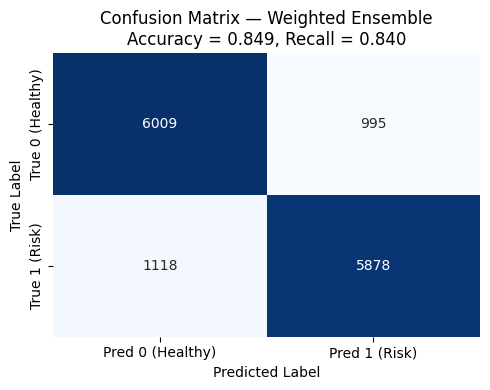

Saved confusion matrix to: /content/model_results/confusion_matrix_weighted.png


In [ ]:
# Cell 2 — Confusion Matrix for Weighted Ensemble
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_weighted)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0 (Healthy)', 'Pred 1 (Risk)'],
            yticklabels=['True 0 (Healthy)', 'True 1 (Risk)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f"Confusion Matrix — Weighted Ensemble\nAccuracy = {accuracy:.3f}, Recall = {recall:.3f}")
plt.tight_layout()
cm_path = os.path.join(RESULTS_DIR, "confusion_matrix_weighted.png")
plt.savefig(cm_path, dpi=200, bbox_inches='tight')
plt.show()
print("Saved confusion matrix to:", cm_path)

In [ ]:
# Cell 1 - load metric table and holdout probs robustly
import os, pandas as pd, numpy as np, joblib

RESULTS_DIR = "/content/model_results"  # change if needed
# Try alternate path
if not os.path.exists(RESULTS_DIR):
    RESULTS_DIR = "/mnt/data/model_results" if os.path.exists("/mnt/data/model_results") else "."

# load model metrics if present
metrics_csv = os.path.join(RESULTS_DIR, "model_metrics_summary.csv")
if os.path.exists(metrics_csv):
    metrics_df = pd.read_csv(metrics_csv)
else:
    # try other names
    candidates = [f for f in os.listdir(RESULTS_DIR) if "metrics" in f.lower() or "model" in f.lower()]
    metrics_df = pd.read_csv(os.path.join(RESULTS_DIR, candidates[0])) if candidates else pd.DataFrame()
print("Loaded metrics_df shape:", metrics_df.shape)

# Load holdout probabilities (ensemble_predictions_weighted.csv or holdout_base_probs.csv)
holdout_paths = [
    os.path.join(RESULTS_DIR, "ensemble_predictions_weighted.csv"),
    os.path.join(RESULTS_DIR, "holdout_base_probs.csv"),
    os.path.join(RESULTS_DIR, "holdout_meta_preds.csv")
]
hold = None
for p in holdout_paths:
    if os.path.exists(p):
        hold = pd.read_csv(p)
        print("Loaded holdout probs from:", p)
        break

if hold is None:
    raise FileNotFoundError(f"No holdout predictions CSV found in {RESULTS_DIR}. Expected one of: {holdout_paths}")

# normalize column names to expected forms
cols = [c.lower() for c in hold.columns]
# try to detect y_test and probs
y_col = next((c for c in hold.columns if 'y' in c.lower() and 'test' in c.lower()) , None)
if y_col is None:
    # fallback heuristics
    y_col = next((c for c in hold.columns if c.lower() in ['y_test','ytrue','target','label','true']), None)
p_xgb_col = next((c for c in hold.columns if 'xgb' in c.lower() and 'p' in c.lower()), None)
p_cat_col = next((c for c in hold.columns if 'cat' in c.lower() and 'p' in c.lower()), None)
p_weight_col = next((c for c in hold.columns if 'weighted' in c.lower() or 'ensemble' in c.lower()), None)

# If p_weight missing but p_xgb and p_cat present, compute it
if p_weight_col is None and p_xgb_col and p_cat_col:
    hold['p_weighted'] = 0.5 * hold[p_xgb_col] + 0.5 * hold[p_cat_col]
    p_weight_col = 'p_weighted'

print("Detected columns -> y:", y_col, "p_xgb:", p_xgb_col, "p_cat:", p_cat_col, "p_weighted:", p_weight_col)
y_test = hold[y_col].values if y_col else None
p_xgb = hold[p_xgb_col].values if p_xgb_col else None
p_cat = hold[p_cat_col].values if p_cat_col else None
p_weight = hold[p_weight_col].values if p_weight_col else None

Loaded metrics_df shape: (6, 7)
Loaded holdout probs from: /content/model_results/ensemble_predictions_weighted.csv
Detected columns -> y: y_test p_xgb: p_xgb p_cat: p_cat p_weighted: p_weighted


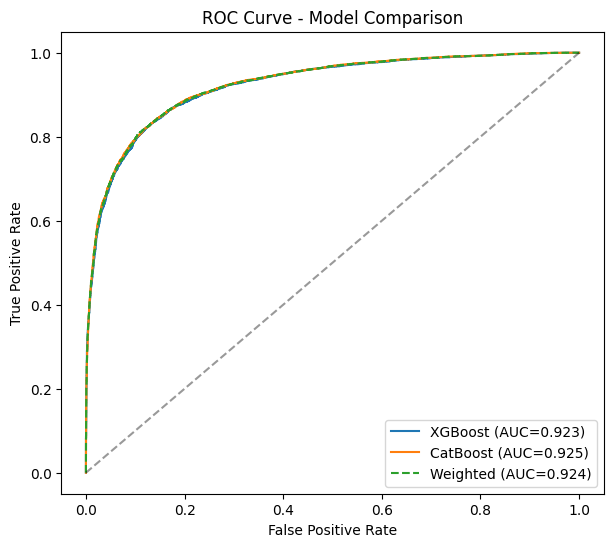

Saved ROC overlay to: /content/model_results/roc_overlay_all_models.png


In [ ]:
# Cell 2 - ROC overlay and save png
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(7,6))
if p_xgb is not None:
    fpr, tpr, _ = roc_curve(y_test, p_xgb); auc_x = roc_auc_score(y_test, p_xgb)
    plt.plot(fpr, tpr, label=f"XGBoost (AUC={auc_x:.3f})")
if p_cat is not None:
    fpr, tpr, _ = roc_curve(y_test, p_cat); auc_c = roc_auc_score(y_test, p_cat)
    plt.plot(fpr, tpr, label=f"CatBoost (AUC={auc_c:.3f})")
if p_weight is not None:
    fpr, tpr, _ = roc_curve(y_test, p_weight); auc_w = roc_auc_score(y_test, p_weight)
    plt.plot(fpr, tpr, '--', label=f"Weighted (AUC={auc_w:.3f})")

plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Model Comparison")
plt.legend(loc='lower right')
out = os.path.join(RESULTS_DIR, "roc_overlay_all_models.png")
plt.savefig(out, dpi=200, bbox_inches='tight')
plt.show()
print("Saved ROC overlay to:", out)

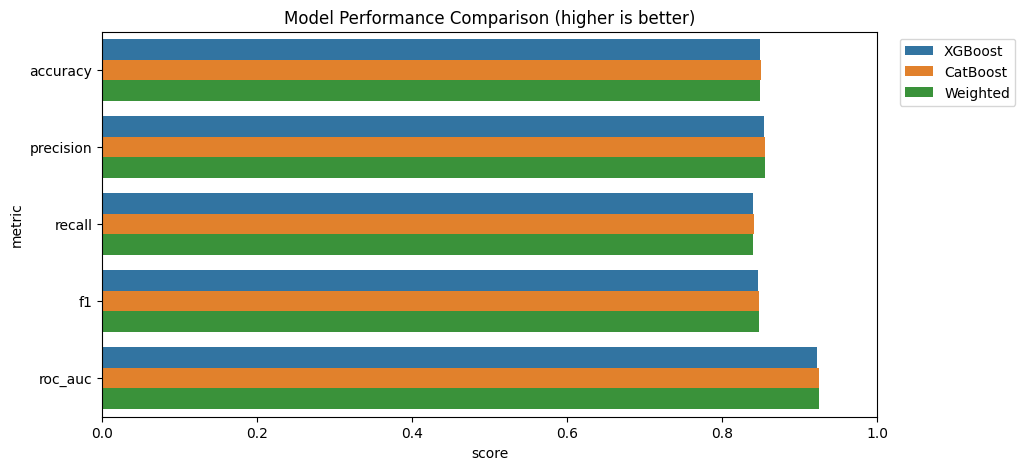

Saved performance comparison to: /content/model_results/model_performance_comparison.png


In [ ]:
# Cell 3 - performance bar chart & save png
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

rows = []
# helper to safely compute metrics if prob available
def safe_metrics(name, probs):
    if probs is None:
        return None
    preds = (np.array(probs) >= 0.5).astype(int)
    return {
        "model": name,
        "accuracy": accuracy_score(y_test, preds),
        "precision": precision_score(y_test, preds),
        "recall": recall_score(y_test, preds),
        "f1": f1_score(y_test, preds),
        "roc_auc": roc_auc_score(y_test, probs)
    }

for name, probs in [("XGBoost", p_xgb), ("CatBoost", p_cat), ("Weighted", p_weight)]:
    m = safe_metrics(name, probs)
    if m:
        rows.append(m)

perf_df = pd.DataFrame(rows)
perf_df = perf_df.melt(id_vars='model', var_name='metric', value_name='score')
plt.figure(figsize=(10,5))
sns.barplot(data=perf_df, x='score', y='metric', hue='model', orient='h')
plt.title("Model Performance Comparison (higher is better)")
plt.xlim(0,1)
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
out2 = os.path.join(RESULTS_DIR, "model_performance_comparison.png")
plt.savefig(out2, dpi=200, bbox_inches='tight')
plt.show()
print("Saved performance comparison to:", out2)

In [ ]:
# Option A: write processed_feature_names list to disk
import os
RESULTS_DIR = "/content/model_results"  # change if your path differs

# processed_feature_names should be a Python list already in your session
# Example: processed_feature_names = ['age_years','BMI','ap_hi', ...]
try:
    with open(os.path.join(RESULTS_DIR, "processed_feature_names.txt"), "w") as f:
        for name in processed_feature_names:
            f.write(f"{name}\n")
    print("Wrote processed_feature_names.txt to", RESULTS_DIR)
except NameError:
    print("processed_feature_names not found in session. Use Option B below.")

Wrote processed_feature_names.txt to /content/model_results


Loaded CatBoost model from: /content/model_results/CatBoost.joblib


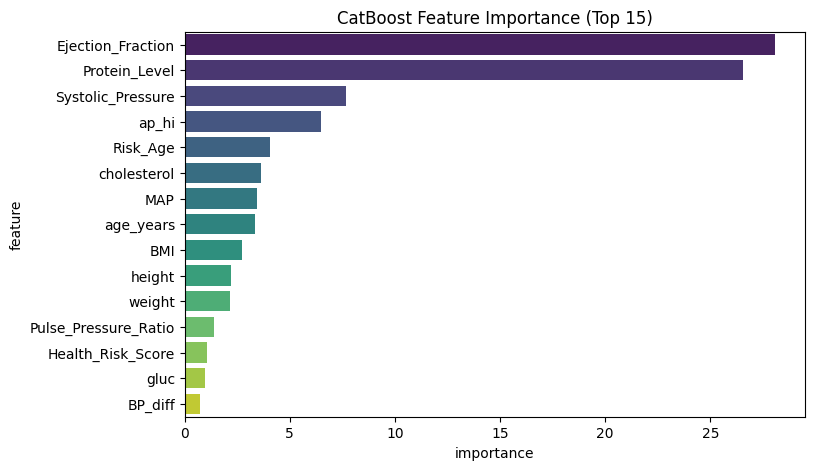

Saved CatBoost feature importance to: /content/model_results/catboost_feature_importance_top15.png


In [ ]:
# Cell 4 - CatBoost feature importance
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

# Try to load CatBoost model file from results dir (common names)
possible_names = ["catboost.joblib","CatBoost.joblib","cat_full.joblib","cat_model.joblib","CatBoost_model.joblib"]
cat_model = None
for fname in possible_names:
    path = os.path.join(RESULTS_DIR, fname)
    if os.path.exists(path):
        try:
            cat_model = joblib.load(path)
            print("Loaded CatBoost model from:", path)
            break
        except Exception:
            # Added a basic except block to catch potential loading errors
            pass

# If model not found, look for feature importance CSV
fi_csv_candidates = [f for f in os.listdir(RESULTS_DIR) if 'feature' in f.lower() and (f.endswith('.csv') or f.endswith('.png'))]
fi = None
if cat_model is not None:
    try:
        # CatBoost provides get_feature_importance; for sklearn wrapper use feature_importances_
        if hasattr(cat_model, "get_feature_importance"):
            importances = cat_model.get_feature_importance()
        elif hasattr(cat_model, "feature_importances_"):
            importances = cat_model.feature_importances_
        else:
            raise RuntimeError("Model has no feature importances attribute usable.")
        # map to processed feature names if available
        feat_names_path = os.path.join(RESULTS_DIR, "processed_feature_names.txt")
        if os.path.exists(feat_names_path):
            with open(feat_names_path) as f:
                feat_names = [l.strip() for l in f.readlines()]
        else:
            # Use default names if file not found
            feat_names = [f"f{i}" for i in range(len(importances))]
            print("processed_feature_names.txt not found. Using default feature names.")

        fi = pd.DataFrame({"feature": feat_names, "importance": importances})

    except Exception as e:
        print(f"Error extracting feature importance from model: {e}")
        # If error extracting from model, fallback to CSV candidates
        if fi_csv_candidates:
            fi = pd.read_csv(os.path.join(RESULTS_DIR, fi_csv_candidates[0]))
            print("Loaded feature importance CSV as fallback:", fi_csv_candidates[0])
        else:
            raise FileNotFoundError("Could not find CatBoost model feature importance or feature importance CSV in RESULTS_DIR.") from e

elif fi_csv_candidates:
    fi = pd.read_csv(os.path.join(RESULTS_DIR, fi_csv_candidates[0]))
    print("Loaded feature importance CSV:", fi_csv_candidates[0])
else:
    raise FileNotFoundError("Could not find CatBoost model or feature importance CSV in RESULTS_DIR.")

# Plot top 15
fi = fi.sort_values("importance", ascending=False).head(15)
plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=fi, palette='viridis', hue='feature', legend=False)
plt.title("CatBoost Feature Importance (Top 15)")
out3 = os.path.join(RESULTS_DIR, "catboost_feature_importance_top15.png")
plt.savefig(out3, dpi=200, bbox_inches='tight')
plt.show()
print("Saved CatBoost feature importance to:", out3)

Loaded CatBoost model from: /content/model_results/CatBoost.joblib


/tmp/ipython-input-2154906082.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=fi, palette='viridis')


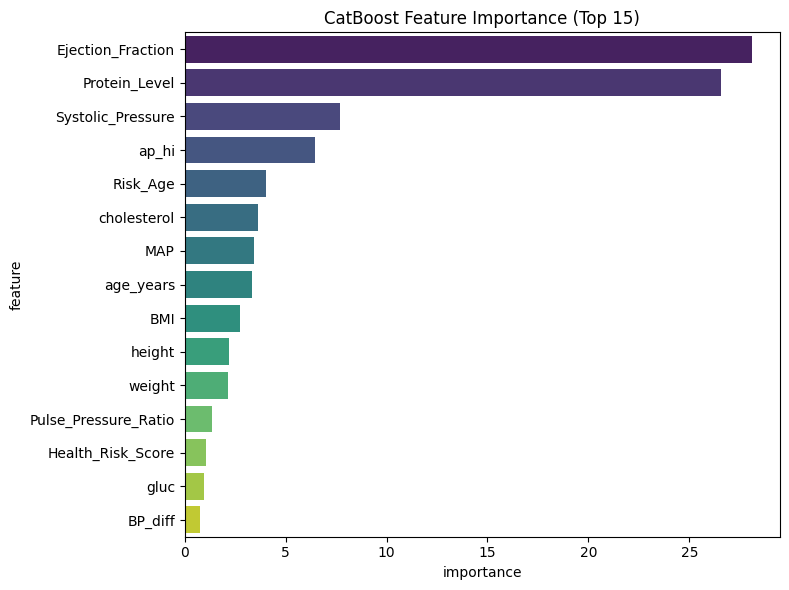

Saved CatBoost feature importance to: /content/model_results/catboost_feature_importance_top15_named.png


In [ ]:
# Cell A - CatBoost feature importance with real processed names
import os, joblib, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np

RESULTS_DIR = "/content/model_results"
if not os.path.exists(RESULTS_DIR):
    RESULTS_DIR = "/mnt/data/model_results" if os.path.exists("/mnt/data/model_results") else "."

# load processed feature names
pf_path = os.path.join(RESULTS_DIR, "processed_feature_names.txt")
if os.path.exists(pf_path):
    with open(pf_path) as f:
        feat_names = [l.strip() for l in f.readlines()]
else:
    feat_names = None

# locate cat model
possible = ["catboost.joblib","CatBoost.joblib","cat_full.joblib","cat_model.joblib","CatBoost_model.joblib","CatBoost_model.joblib"]
cat_model = None
for p in possible:
    fp = os.path.join(RESULTS_DIR, p)
    if os.path.exists(fp):
        try:
            cat_model = joblib.load(fp)
            print("Loaded CatBoost model from:", fp)
            break
        except Exception as e:
            print("Found but couldn't load", fp, "->", e)

if cat_model is None:
    raise FileNotFoundError("No CatBoost model found in RESULTS_DIR. Save your CatBoost model to one of the filenames above.")

# get importances
if hasattr(cat_model, "get_feature_importance"):
    importances = np.array(cat_model.get_feature_importance())
elif hasattr(cat_model, "feature_importances_"):
    importances = np.array(cat_model.feature_importances_)
else:
    raise RuntimeError("Cannot extract feature importances from loaded CatBoost object.")

# build dataframe with names if available
if feat_names is not None and len(feat_names) == len(importances):
    fi = pd.DataFrame({"feature": feat_names, "importance": importances})
else:
    fi = pd.DataFrame({"feature": [f"f{i}" for i in range(len(importances))], "importance": importances})
fi = fi.sort_values("importance", ascending=False).head(15)

# plot
plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=fi, palette='viridis')
plt.title("CatBoost Feature Importance (Top 15)")
outp = os.path.join(RESULTS_DIR, "catboost_feature_importance_top15_named.png")
plt.tight_layout()
plt.savefig(outp, dpi=200, bbox_inches='tight')
plt.show()
print("Saved CatBoost feature importance to:", outp)

In [ ]:
# Cell B - SHAP summary + force plot for CatBoost
import os, joblib, numpy as np, matplotlib.pyplot as plt, shap, pandas as pd

RESULTS_DIR = "/content/model_results"
if not os.path.exists(RESULTS_DIR):
    RESULTS_DIR = "/mnt/data/model_results" if os.path.exists("/mnt/data/model_results") else "."

# load cat model if not in session
try:
    cat_model
except NameError:
    # try common filenames
    for fname in ["cat_full.joblib","cat_model.joblib","CatBoost.joblib","catboost.joblib"]:
        fp = os.path.join(RESULTS_DIR, fname)
        if os.path.exists(fp):
            cat_model = joblib.load(fp)
            print("Loaded CatBoost model from:", fp)
            break

# find processed feature names
pf = os.path.join(RESULTS_DIR, "processed_feature_names.txt")
if os.path.exists(pf):
    with open(pf) as f:
        feat_names = [l.strip() for l in f.readlines()]
else:
    feat_names = None

# get X_test (processed) and y_test from session if available
X_test_proc = None
try:
    X_test_proc = X_test  # from earlier pipeline (numpy)
    print("Using in-memory X_test.")
except Exception:
    # try to reconstruct from preprocessor and X_test_raw
    try:
        preproc = joblib.load(os.path.join(RESULTS_DIR, "preprocessor.joblib"))
        X_test_raw = pd.read_csv(os.path.join(RESULTS_DIR, "holdout_base_probs.csv"))  # fallback guess (may not contain raw)
        print("preprocessor loaded; but raw X_test not found automatically. If this fails, please provide X_test or preprocessor and X_test_raw.")
    except Exception:
        pass

if X_test_proc is None:
    raise RuntimeError("X_test (processed features) not found in session. SHAP needs feature matrix. Provide X_test (processed numpy array) or run the preprocessing transform and set variable X_test.")

# Create a lightweight sample to speed SHAP
sample_idx = np.random.choice(X_test_proc.shape[0], size=min(2000, X_test_proc.shape[0]), replace=False)
X_shap = X_test_proc[sample_idx]

# SHAP
explainer = shap.TreeExplainer(cat_model)
shap_vals = explainer.shap_values(X_shap)

# summary plot (class 1)
plt.figure(figsize=(10,6))
shap.summary_plot(shap_vals, X_shap, feature_names=feat_names if feat_names else None, show=False)
sum_png = os.path.join(RESULTS_DIR, "shap_summary_cat.png")
plt.savefig(sum_png, dpi=200, bbox_inches='tight')
plt.close()
print("Saved SHAP summary to:", sum_png)

# force plot for one representative positive sample (highest predicted prob)
probs = cat_model.predict_proba(X_test_proc)[:,1]
idx = int(np.argmax(probs))  # pick highest risk sample
sv = explainer.shap_values(X_test_proc[idx:idx+1])
# SHAP force plot (HTML) and static save via matplotlib
shap.initjs()
force_html = os.path.join(RESULTS_DIR, "shap_force_sample.html")
shap.force_plot(explainer.expected_value, sv, X_test_proc[idx:idx+1], feature_names=feat_names if feat_names else None, matplotlib=True, show=False)
# save matplotlib-rendered force as PNG
fp_png = os.path.join(RESULTS_DIR, "shap_force_highest_risk.png")
plt.savefig(fp_png, dpi=200, bbox_inches='tight')
plt.close()
print("Saved SHAP force plot (PNG) to:", fp_png)

Using in-memory X_test.
Saved SHAP summary to: /content/model_results/shap_summary_cat.png


Saved SHAP force plot (PNG) to: /content/model_results/shap_force_highest_risk.png


In [ ]:
# Cell B - SHAP summary + force plot for CatBoost
import os, joblib, numpy as np, matplotlib.pyplot as plt, shap, pandas as pd

RESULTS_DIR = "/content/model_results"
if not os.path.exists(RESULTS_DIR):
    RESULTS_DIR = "/mnt/data/model_results" if os.path.exists("/mnt/data/model_results") else "."

# load cat model if not in session
try:
    cat_model
except NameError:
    # try common filenames
    for fname in ["cat_full.joblib","cat_model.joblib","CatBoost.joblib","catboost.joblib"]:
        fp = os.path.join(RESULTS_DIR, fname)
        if os.path.exists(fp):
            cat_model = joblib.load(fp)
            print("Loaded CatBoost model from:", fp)
            break

# find processed feature names
pf = os.path.join(RESULTS_DIR, "processed_feature_names.txt")
if os.path.exists(pf):
    with open(pf) as f:
        feat_names = [l.strip() for l in f.readlines()]
else:
    feat_names = None

# get X_test (processed) and y_test from session if available
X_test_proc = None
try:
    X_test_proc = X_test  # from earlier pipeline (numpy)
    print("Using in-memory X_test.")
except Exception:
    # try to reconstruct from preprocessor and X_test_raw
    try:
        preproc = joblib.load(os.path.join(RESULTS_DIR, "preprocessor.joblib"))
        X_test_raw = pd.read_csv(os.path.join(RESULTS_DIR, "holdout_base_probs.csv"))  # fallback guess (may not contain raw)
        print("preprocessor loaded; but raw X_test not found automatically. If this fails, please provide X_test or preprocessor and X_test_raw.")
    except Exception:
        pass

if X_test_proc is None:
    raise RuntimeError("X_test (processed features) not found in session. SHAP needs feature matrix. Provide X_test (processed numpy array) or run the preprocessing transform and set variable X_test.")

# Create a lightweight sample to speed SHAP
sample_idx = np.random.choice(X_test_proc.shape[0], size=min(2000, X_test_proc.shape[0]), replace=False)
X_shap = X_test_proc[sample_idx]

# SHAP
explainer = shap.TreeExplainer(cat_model)
shap_vals = explainer.shap_values(X_shap)

# summary plot (class 1)
plt.figure(figsize=(10,6))
shap.summary_plot(shap_vals, X_shap, feature_names=feat_names if feat_names else None, show=False)
sum_png = os.path.join(RESULTS_DIR, "shap_summary_cat.png")
plt.savefig(sum_png, dpi=200, bbox_inches='tight')
plt.close()
print("Saved SHAP summary to:", sum_png)

# force plot for one representative positive sample (highest predicted prob)
probs = cat_model.predict_proba(X_test_proc)[:,1]
idx = int(np.argmax(probs))  # pick highest risk sample
sv = explainer.shap_values(X_test_proc[idx:idx+1])
# SHAP force plot (HTML) and static save via matplotlib
shap.initjs()
force_html = os.path.join(RESULTS_DIR, "shap_force_sample.html")
shap.force_plot(explainer.expected_value, sv, X_test_proc[idx:idx+1], feature_names=feat_names if feat_names else None, matplotlib=True, show=False)
# save matplotlib-rendered force as PNG
fp_png = os.path.join(RESULTS_DIR, "shap_force_highest_risk.png")
plt.savefig(fp_png, dpi=200, bbox_inches='tight')
plt.close()
print("Saved SHAP force plot (PNG) to:", fp_png)

Using in-memory X_test.
Saved SHAP summary to: /content/model_results/shap_summary_cat.png


Saved SHAP force plot (PNG) to: /content/model_results/shap_force_highest_risk.png


In [ ]:
# Cell C - export models and preprocessor for submission
import os, joblib, pickle

RESULTS_DIR = "/content/model_results"
if not os.path.exists(RESULTS_DIR):
    RESULTS_DIR = "/mnt/data/model_results" if os.path.exists("/mnt/data/model_results") else "."

os.makedirs(os.path.join(RESULTS_DIR,"final_models"), exist_ok=True)
outdir = os.path.join(RESULTS_DIR,"final_models")

# list candidates and copy/save them to final_models
candidates = {
    "xgb_full": ["xgb_full.joblib","XGBoost.joblib","xgboost.joblib","XGBoost_model.joblib"],
    "cat_full": ["cat_full.joblib","CatBoost.joblib","catboost.joblib","cat_model.joblib"],
    "meta": ["MetaLR.joblib","meta_lr.joblib","meta.joblib"]
}
found = {}
for key, names in candidates.items():
    for n in names:
        p = os.path.join(RESULTS_DIR, n)
        if os.path.exists(p):
            joblib.dump(joblib.load(p), os.path.join(outdir, n))
            found[key] = os.path.join(outdir, n)
            break

# save preprocessor if exists in session or in resultsdir
try:
    joblib.dump(preprocessor, os.path.join(outdir, "preprocessor.joblib"))
    print("Saved preprocessor from memory to:", os.path.join(outdir, "preprocessor.joblib"))
except Exception:
    # try to find preprocessor.joblib in RESULTS_DIR
    if os.path.exists(os.path.join(RESULTS_DIR, "preprocessor.joblib")):
        joblib.dump(joblib.load(os.path.join(RESULTS_DIR, "preprocessor.joblib")), os.path.join(outdir, "preprocessor.joblib"))
        print("Copied preprocessor.joblib to final_models")
    else:
        print("No preprocessor found in session or RESULTS_DIR; you should save it before deployment.")

# save ensemble weights file if exists
weights_src = os.path.join(RESULTS_DIR, "ensemble_weights.pkl")
if os.path.exists(weights_src):
    joblib.dump(joblib.load(weights_src), os.path.join(outdir,"ensemble_weights.pkl"))
    print("Saved ensemble_weights.pkl to final_models")
else:
    print("ensemble_weights.pkl not found; create and save it if needed.")

print("Final models saved to:", outdir)

Saved preprocessor from memory to: /content/model_results/final_models/preprocessor.joblib
Saved ensemble_weights.pkl to final_models
Final models saved to: /content/model_results/final_models


In [ ]:
# Cell D - write Streamlit app skeleton (simple)
app_py = """
import streamlit as st
import joblib
import pandas as pd
import numpy as np

st.title('Heart Attack Risk Predictor (Ensemble Demo)')

# load models and preprocessor
model_dir = "model_results/final_models"
preproc = joblib.load(model_dir + "/preprocessor.joblib")
xgb = joblib.load(model_dir + "/xgb_full.joblib")
cat = joblib.load(model_dir + "/cat_full.joblib")
weights = joblib.load(model_dir + "/ensemble_weights.pkl") if (model_dir + "/ensemble_weights.pkl") else {'w_xgb':0.5,'w_cat':0.5}

# example inputs - replace/add all your features as needed
age = st.number_input("Age (years)", min_value=20, max_value=120, value=50)
height = st.number_input("Height (cm)", min_value=100, max_value=220, value=170)
weight = st.number_input("Weight (kg)", min_value=30, max_value=200, value=70)
# ... add other feature UI elements here ...

if st.button("Predict (example)"):
    # build input_df matching your raw features order
    input_df = pd.DataFrame([{
        'age_years': age,
        'height': height,
        'weight': weight,
        # ... fill out other required features with defaults or UI values ...
    }])
    Xp = preproc.transform(input_df)
    p_xgb = xgb.predict_proba(Xp)[:,1]
    p_cat = cat.predict_proba(Xp)[:,1]
    p_ens = weights.get('w_xgb',0.5) * p_xgb + weights.get('w_cat',0.5) * p_cat
    st.write(f"Ensemble risk probability: {p_ens[0]:.3f}")
"""
with open("/content/streamlit_app.py","w") as f:
    f.write(app_py)
print("Streamlit app skeleton saved to /content/streamlit_app.py")
print("To run locally: streamlit run streamlit_app.py")

Streamlit app skeleton saved to /content/streamlit_app.py
To run locally: streamlit run streamlit_app.py


In [ ]:
!zip -r /content/submission_package.zip /content/model_results

  adding: content/model_results/ (stored 0%)
  adding: content/model_results/catboost_feature_importance_top15_named.png (deflated 23%)
  adding: content/model_results/shap_force_highest_risk.png (deflated 13%)
  adding: content/model_results/LightGBM.joblib (deflated 58%)
  adding: content/model_results/ensemble_predictions_weighted.csv (deflated 56%)
  adding: content/model_results/CatBoost.joblib (deflated 56%)
  adding: content/model_results/ensemble_weights.pkl (deflated 34%)
  adding: content/model_results/XGBoost.joblib (deflated 67%)
  adding: content/model_results/model_performance_comparison.png (deflated 24%)
  adding: content/model_results/RandomForest.joblib (deflated 76%)
  adding: content/model_results/shap_summary_cat.png (deflated 8%)
  adding: content/model_results/model_metrics_summary.csv (deflated 50%)
  adding: content/model_results/processed_feature_names.txt (deflated 47%)
  adding: content/model_results/acc_recall_comparison.png (deflated 25%)
  adding: content

In [ ]:
from google.colab import drive
drive.mount('/content/drive')